In [3]:
# Importing everything required 

#Webscraping
import requests
import bs4
from bs4 import BeautifulSoup
import re
import time
import random

#Useful data wrangling + maths
import pandas as pd
import numpy as np

#Modelling and preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC #Support vector classifier, not possible given size of dataset but would've been nice to investigate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#NLP
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

#Plotting
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import seaborn as sns
#Set palette
cmap = ListedColormap(sns.color_palette("husl", 3))

# Executive Summary 

The problem, as it stands, is that is it is hard to get funding and it is also hard to get published if you are a research scientist. Additionally, the process involves slightly modifying manuscripts and resubmitting them to review bodies; this is tedious and expensive and it is a part of the job that no scientist looks forward to. I set out to create a tool which would determine via classification which journals an authors should submit their manuscript to. I wanted to perform a variety of classification models and to search through many iterations of hyper parameters and feature transformations in order to construct a classification model that has an accuracy higher than baseline (guessing the majority class).

I found that there are far too many journals in the world of scientific literature to be a realistic target for multi-class classification, thus I was required to perform some feature engineering to scale down the scope of the problem, and I settled on attempting to classify articles into scientific fields (e.g. biology, chemistry). I also discovered significant nuance to certain journals that leads me to believe that this is a problem that could be tackled, but it is likely a case of ‘chasing a magic dataset’. I also found that none of my models had higher accuracy than simply guessing at baseline. 

I conclude that there is more difference in corpus composition within scientific fields than there is between them at the level of granularity to which I examined. Ultimately, I conclude that the data that I have cannot be used to answer the questions I have asked: can we classify scientific articles into their respective domains? No.

In future versions of this project, I would like to look at within field differences, as scientists largely know which field, they should apply their research to before they do it, the most useful output label would be a specific journal. In order to do this, I need to seriously limit the range of labels (target journals) in any future datasets.


# Ultimate question 


---

# Can I use scientific article data to train a machine-learning classification model to classify articles as belonging to a specific scientific domain?

---


<br>

For my project, these labels are Medicine, Biology, Chemistry, Physics. The process of why these classes have been chosen is outlined in my readme and also below.

<br>

# Where am I sourcing the data?


---

<br>

I initially attempted to the article API of https://pubmed.ncbi.nlm.nih.gov as documentation suggested that this API would be able to provide different versions of manuscripts (before and after approval) and, conceptually, I liked the idea of training data on both denied and approved submissions (in a complete end-to-end tool, predicting that a manuscript is unlikely to be published in its current state is perhaps a useful feature). In practice this API housed essentially no information about the actual articles and only included internal codes relating to stages in the submission process various articles went through. The actual articles this data related to was not possible to find due to the practice of restricting the content of scientific articles behind paywalls. I therefore chose to use the requests and BeatifulSoup libraries to scrape, and parse through, the HTML of a site that hosts scientific articles.

I am sourcing the data for scientific articles from https://pubmed.ncbi.nlm.nih.gov/{article_number}. This site hosts a large database of scientific articles with a focus on medicine (and to a lesser extent, biology).

There were a few considerations as to why this site was chosen over others:

    a) This site contains meta-information about scientific articles (e.g. keyword tags, article language).
    
    b) Scientific article abstracts are available as plain text HTML from this site.
            - Abstracts can be thought of as summaries of a piece of scientific literature.
            
    c)  i) Articles can be easily iterated through with a simple for loop and a range of articles page numbers
        ii) There is one article per page
    
    d) This site doesn't mind being scraped: doesn't return fake HTML or captchas which occured with other sites
    

One problem I ran into when cleaning data, which I will mention now because it is relevant, is that scientific journals are commonly abbreviated (and were in my scraped dataset). Unbeknown to myself when I initially started scraping, this site has a convenient search function that I was able to manipulate to retrieve the full name of the journals from the abbreviation (the relevance of this is discussed later). I strongly suspect that I would have needed to do this had I sourced the data from a different site and am simply grateful that with pubmed it wasn't a headache.

<br>

<br>

In [2]:
# This cell was used for testing requests:

# url = 'https://pubmed.ncbi.nlm.nih.gov/31052024/'

# r = requests.get(url)
# soup = BeautifulSoup(r.text, 'html.parser')

# test_auths_w_affiliations = get_authors_w_affil(soup)
# test_affs = get_affiliations(soup)

### Functions used to parse the HTML

In [ ]:
### Getting article data

def get_pub_date(page):
    try:# keeping only date
        return re.search('^[^;]+', page.find('span', attrs = {"cit"}).text.strip())[0]
    except:
        return np.nan

def get_title(page):
    try:
        return page.find('h1', attrs = {"heading-title"}).text.strip()
    except:
        return np.nan

def get_abstract(page):
    try:#this gives a list of the different sections (if there are sections) and gets rid of any \n followed by white space and turns it into signle document 
        return re.sub('[\\][\\n]+[\s]+', ' ' , 
                      re.split('Keywords:(\\n\s+)+.+', page.find("div", attrs = {"abstract"}).text)[0]).strip() #have to strip keywords off
    except:
        return np.nan

def get_article_type(page):
    try:
        return page.find("div", attrs = {"publication-type"}).text.strip() 
    except:
        return np.nan
    
def get_journal(page):
    try:
        return page.find("div", attrs = {"article-source"}).find("button").text.strip()
    except:
        return np.nan    
    
def get_art_language(page): 
    try:
        return page.find("div", attrs = {"article-languages"}).text.strip()
    except:
        return np.nan

def get_tags(page):
    try:# this splits the abstract body of the text into body and keywords, w/ keywords at index [1]
        return re.split('Keywords:(\\n\s+)+.[^A-z]', page.find("div", attrs = {"abstract"}).text.strip())[-1]
    except:
        return np.nan

    
### Getting authors and their affiliations

# Quite a lot longer to do this: need to go into authors list and affiliations list
# Pull out each author and match the affiliation link number with the link 
# I never actually ended up using this data as a predictor because it is very tricky to justify the way to use it (explained later)

def get_authors(page):
    try: #returns a list of the full names of all the authors 
        return ', '.join([i.find("a", attrs = {"full-name"}).text for i in page.find("div", attrs = {"authors-list"}).find_all("span", attrs = {"authors-list-item"})])
    except:
        return np.nan

def get_authors_w_affil(page):
    try: #returns a list of the full names of all the authors in tuples with a list of the affiliation links  
        return [(i.find("a", attrs = {"full-name"}).text, re.search('[\d]', i.find("sup", attrs = {"affiliation-links"}).text)[0]) 
                for i in page.find("div", attrs = {"authors-list"}).find_all("span", attrs = {"authors-list-item"})]
    except:
        return np.nan  

# I can turn this into a df by iterating through the tuples and commiting the id and name to a df, then joining to a df from below
# Will need to have separate dfs for each page and then commit each finalised df to a separate df 

def get_affiliations(page):
    try: #splitting the numbered list up to essentially make an array 
        return [re.split('[\s]', j, maxsplit=1) for j in  
                                    [i.text for i in page.find('div', attrs = {"affiliations"}).find_all('li')]]
    except:
        return np.nan
    

# Function to do the pairing mentioned above, keeping the notes above as it is relevant to the output of the functions

def author_affiliation_pairer(authors, affiliations):
    
    auth_df = pd.DataFrame(authors, columns = [ 'author','loc_key'])
    affs_df = pd.DataFrame(affiliations, columns = [ 'loc_key','affiliation'])
    
    joined_df = pd.merge(auth_df, affs_df, on = 'loc_key', how = 'outer')
    joined_df.dropna(inplace=True)
    joined_df.drop(columns=['loc_key'], inplace=True)
    return joined_df


# Here is one way I tried to use the author data:

# Get the data for the papers, go with only lead author, then scrape google scholar to get number of citations (this is a conceivably useful predictor) 
# Going to need to clean the data a bit (author and institution col) - and then zip together 

# url =  'https://scholar.google.com/citations?hl=en&view_op=search_authors&mauthors=john+smith'
    
# r = requests.get(url)
# soup = BeautifulSoup(r.text, 'html.parser')

# # Google html tags must be intentionally hard to understand, they also change so this function will likely need tweaking

# def get_citations(soup):
#     try: #this tells us if any author/institutions combos give more than one results and QQQ flags these rows for procedural/manual lookup
#         return 'QQQ' + soup.find("div", attrs = {"gsc_1usr"}).find_next_sibling().find("div", attrs = {"gs_ai_cby"}).text
#     except:
#         try: #return number of citations only
#             return re.search('[\d].+', soup.find("div", attrs = {"gsc_1usr"}).find("div", attrs = {"gs_ai_cby"}).text)[0]
#         except: #return NaN so we can drop these rows easily
#             return np.nan


<br>

Here I have written some functions with BeautifulSoup to parse through the HTML and extract article data.

I have also spent time writing functions that will store the authors and the institutions that they are affiliated with in a dataframe of results. This isn't used in this iteration of the project due to difficulties justifying how to use the data.

### Scraping the data for scientific articles 

In [ ]:
# Set up empty dataframes to store the data from each article you scrape. This is discussed in more depth in markdown below.

article_data = pd.DataFrame(columns = ('date', 'title', 'abstract', 'journal', 'tags', 'authors', 'art_type', 'art_lang'))
author_affils_data = pd.DataFrame(columns = ('author', 'loc_name')) #loc_name = location name of affiliated institution

# Initiate time randomness - for some reason I decided I wanted to build my own random number generator (not really but I explain)
# I wanted to make sure there was no regularity to any kind of decimal place, and by dividing a prime number by increasing 
# fibonacci numbers I can achieve that
fibonacci_series = [0,1,1]


# Some custom params for a start point and a max number of results
# These are the numbers you change to get a range of data  
range_start = 5000000
max_results = 20000
step = 499

# Incremement the page number by the step - This site is nice to scrape as all articles have a common root (no root)
# And a unique ID number that can be very easily iterated through

for page_number in range(range_start, (range_start + (max_results*step)), step): 
    
### ESTABLISHING THE SCRAPE SITE

    #update url
    url = f"https://pubmed.ncbi.nlm.nih.gov/{page_number}/"
    r = requests.get(url)
    page = BeautifulSoup(r.text, 'html.parser')

### GETTING ARTICLE DATA

    # setting up lists to append the data I want to, these will be turned into a 1 row df and then vertically concat'd with article_data 
    date = []
    title = []
    abstract = []
    journal = []
    tags = []
    authors = []
    art_type = []
    art_lang = []
    
    #get date
    try:
        date.append(get_pub_date(page))
    except:
        date.append(np.nan)

    #get title
    try:
        title.append(get_title(page))
    except:
        title.append(np.nan)
        
    #get abstract
    try:
        abstract.append(get_abstract(page))
    except:
        abstract.append(np.nan)   
    
    #get article type
    try:
        art_type.append(get_article_type(page))
    except:
        art_type.append(np.nan)
        
    
    #get journal article published in
    try:
        journal.append(get_journal(page))
    except:
        journal.append(np.nan)
            
    
    # get language article is printed in
    try:
        art_lang.append(get_art_language(page))
    except:
        art_lang.append(np.nan)
        
    
    # getting keyword tags
    try:
        tags.append(get_tags(page))
    except:
        tags.append(np.nan)
        
        
    #getting authors
    try:
        authors.append(get_authors(page))
    except:
        authors.append(np.nan)
    
    # Putting it all together into a df and joining it vertically to the larger set of results
    
    page_data = pd.DataFrame({'date':date, 
                              'title':title, 
                              'abstract':abstract, 
                              'journal':journal, 
                              'tags':tags, 
                              'authors':authors, 
                              'art_type':art_type, 
                              'art_lang':art_lang})

    article_data = pd.concat([article_data, page_data])
    
# #### DEALING WITH AUTHOR AFFILIATIONS 

    #lists to commit scraped data to
    authors_w_affils = []
    affiliations = []
    
    #getting authors w/ their affiliations
    try:
        authors_w_affils.append(get_authors_w_affil(page))
    except:
        authors_w_affils.append(np.nan)
    
    #get affiliations with their index numbers that corresponf to the numbers in the above function
    try:
        affiliations.append(get_affiliations(page))
    except:
        affiliations.append(np.nan)
    
#     print(authors_w_affils)
#     print(affiliations)
    
    try: # need to specify list index 0 as the functions were coded for the soup which has been just put into another list
        author_affils_data = pd.concat([author_affils_data, author_affiliation_pairer(authors_w_affils[0], affiliations[0])])
    except:
        pass
    
#### TIME DELAY
    
    #next elment in series = sum of its previous two numbers
    nextElement = fibonacci_series[-1] + fibonacci_series[-2]
    #append the element to the series
    fibonacci_series.append(nextElement)
    time.sleep(random.randrange(1, 2)+(fibonacci_series[-1]/(fibonacci_series[-1]+67)))     
    pass


### SAVING THE DATA - ignore the placeholder filenames

article_data.to_csv('test_20karticles11.csv')
author_affils_data.to_csv('test_20kauthor_affils11.csv')

In this cell, I iterate through a range of page numbers and on each page I collect data about the articles on that page.

I am collecting:

- Title
- Abstract 
- Journal of publication
- Date
- Authors
- Author affiliations
- Article languages
- Keyword tags
- Article type (e.g. review, letter-to-the-editor)


In practice I had many copies of this running simultaneously, and I was changing the range start in order to gain a range of articles from a range of years. The final dataset represented 1922-2022, though the majority of the data was between 1960-2021.

I do not intend to use all this information as predictors. Article language will simply be used to ensure my entire corpus is in english as this is necessary for the efficacy of the NLP that will occur later.

Article type I hoped to use, however only a small percentage of the data collected had this tag present in the original HTML so was not included as a predictor. I discuss this column in more detail when I look at it in more depth.

I used keyword tags, title, abstract and date as predictors in my final model, and I used journal of publication to feature engineer a target label, though the processing of these columns is dicussed later in more detail.

---

Additional information I would have liked but proved challenging:

- h-index of author
- Author and tags

I hoped to use the author and author affiliation data as predictors, however in reality this was challenging to justify. Firstly there are enough unique authors that considering each author to be a category and dummying the authors column is unfeasible. Additionally, some articles have one author, some have two, some have ninety; the same is true for institutional affiliations (albeit not as many as ninety). This introduces the problem of how do I reduce a column containing lists of information of varying lengths to a single value. It is possible to treat this as corpus, but names themselves are not unique (for example, there are Smiths publishing in all scientific fields) and even though people are, NLP doesn't know this.

Furthermore, a more fundamentally useful predictor relating to authors of an article is how influential they are. This requires a separate metric (called an h-index) and this is a rolling window of how much an author publishes and how much their work is cited by others. This, however, is not a constant value and will be different for different authors depending on different years of publication. This itself is simply a programming hurdle, but once this is obtained for each author of a paper how can this be reduced to a single value? The issue of different numbers of authors once again crops up. Consider an acclaimed researcher who includes all the graduate students that helped the research as authors; we can have a situation in which a low h-index average that might not reflect the true appeal of the work (i.e. having the name of one acclaimed researcher). For comparison, a likely much higher average can be achieved by a single average researcher, simply due to the fact that graduate students will have an h-index of (or close to) zero.

Why not just take the h-index score of the highest h-index author? Often very accredited authors will be asked to consult via email or a phone call and this can be sufficient to be included as an author! This results in situations like the above one with a low average h-index, except the accredited researcher has only invested 10 minutes of time! Clearly there is going to be a lot of bias if I do either of these transformations. 

Because I couldn't think of an unbiased way to do this and so chose not to pursue these features of articles as predictors.

# Exploring the data

---


In [1]:
#%cd ..\..\..\..\..\GA_Data

C:\Users\rossa\Desktop\GA_Data


## Cleaning

#### Read in data

In [4]:
# Reading in the csvs that were return from the webscrape

# a=pd.read_csv('test_20karticles.csv')
# b=pd.read_csv('test_20karticles2.csv')
# c=pd.read_csv('test_20karticles3.csv')
# d=pd.read_csv('test_20karticles4.csv')
# e=pd.read_csv('test_20karticles5.csv')
# f=pd.read_csv('test_20karticles6.csv')
# g=pd.read_csv('test_20karticles11.csv')
# h=pd.read_csv('test_20karticles12.csv')
# i=pd.read_csv('test_20karticles13.csv')
# j=pd.read_csv('test_20karticles14.csv')
# k=pd.read_csv('test_20karticles15.csv')
# l=pd.read_csv('test_20karticles16.csv')
# m=pd.read_csv('test_20karticles20.csv')
# n=pd.read_csv('test_20karticles22.csv')
# o=pd.read_csv('test_20karticles31.csv')
# p=pd.read_csv('test_20karticles32.csv')
# q=pd.read_csv('test_20karticles33.csv')


# # pandas concat the dfs together vertically
# test = pd.concat([a, b, c, d, e, f, g, h, i , j, k, l, m, n, o, p, q])

In [5]:
test.shape

(259741, 9)

There are over a quarter million rows in this dataset, this will decrease with cleaning as webscrapes are notorious for producing messy data. I knew that I was going to be losing a lot of rows and this was the reason I chose to scrape just over 250 000.

#### General cleaning

In [6]:
#Dropping all rows missing authors, journals or if the article (and therefore abstract) is not in english

df = test.copy() #Working on a copy of the original, this is good practice

df.drop(columns=['Unnamed: 0'], inplace = True) # I forgot about the index = False argument within pd.to_csv() so need to remove the saved axis

#Drop all rows missing journals, authors less relevant to drop but I didn't know that yet as I started cleaning with scrapes still running
df = df[df['authors'].notna()]
df = df[df['journal'].notna()]

#converting all these missing vals to english as tag only exists when in another language but some english tags exist so can't just keep all non-tagged rows
df.art_lang.fillna('english', inplace = True)
df = df[df['art_lang'] == 'english']

# missing article types termed 'undeclared articles' - useful for diagnostics later
df.art_type.fillna('Undeclared', inplace = True)

# missing tags termed none - This will be added to stopwords for this column later
df.tags.fillna('None', inplace = True)

# NEED TO ADD THE SUBHEADING TITLES TO STOPWORDS - all variations of this 
# This required looking at the most commonly occurring values as there were only a few variations and they all occured more than once 
# This shouldn't happen in this column of unique article summaries
df.abstract.replace(to_replace = {'No abstract available': np.nan , 
                                  'Abstract A correction to this article has been published and is linked from the HTML and PDF versions of this paper. The error has not been fixed in the paper.' : np.nan,
                                  'Abstract A correction to this article has been published and is linked from the HTML and PDF versions of this paper. The error has been fixed in the paper.' : np.nan,
                                  'Abstract Text for Correction. ' : np.nan,
                                  'Abstract The PDF and HTML versions of the article have been updated to include the Creative Commons Attribution 4.0 International License information.' : np.nan },
                                   inplace = True)

# Sometimes this would be under the tag part of the HTML, replace with nan so I can drop later
df.tags.replace({'No abstract available': np.nan}, inplace = True)

# For sanity
df.reset_index(drop=True, inplace = True)

<br>This general cleaning was done while the webscrapes were still running and includes preliminary steps. Each one is annotated to describe the purpose and when necessary the steps required to put it together.

---------------------------------------

#### Looking at tags 

In [5]:
# These functions clean the weird cells in the tags column

def abstract_dropper(cell):
    try:
        #clean the white space at the start of cells, that is why multiline enabled
        cell = re.sub(r"^\s+", "", cell, flags = re.MULTILINE)
        #compile pattern to use - this selects everything after the word abstract - sometimes the entire abstract fell under this tag
        pattern = re.compile(r'[Aa]bstract.+')
        #get rid of all white space, replace contents of cells w/o tags with word 'none'
        cell = re.sub(r'[\s]', 'QQQQ', cell) #part b in markdown
        cell = re.sub(pattern, 'none', cell) #part a in markdown
        return cell
    except:
        return cell
    
# To summarise the above function
# a) clean white space from start of string
# b) replace all white space within string with marker
# c) clear contents of cells that start with Abstract (as these cells DO NOT contain real tags)  
    
    
# Replacing the spaces of the cells that are flagged to not be erased - this leaves us w/ keyword tags separated by spaces
def tag_fixer(cell):
    try: #putting the spaces back in
        cell = cell.replace('QQQQ', ' ')
        return cell
    except:
        return cell

# Neatness 
def tag_cleaner(cell):
    return tag_fixer(abstract_dropper(cell))

In [6]:
#This function will be applied to the tags column in prep for TFUDF vectorisation

def tags_formatter(cell):
    #lowercase everything so variations in capitalisation are not considered separately
    cell = cell.lower()
    #replace the ; separating the tags from eachother to make long string or keywords
    cell = cell.replace(';', '')
    #replace anything inside brackets with nothing
    cell = re.sub(r'[(].+[)]', '', cell)
    # replace any of the special characters in the capture expressions
    cell = re.sub(r'[.]|[?]|[!]|[-]', '', cell)
    return cell


# Apply the formatting on the whole df:
df.tags = df.tags.apply(tags_formatter)

C:\Users\rossa\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


This function is necessary to prepare this column for TF-IDF vectorization.

In [4]:
#Applying the cleaning to the tags column
df.tags = df.tags.apply(tag_cleaner)

# Apply the formatting on the whole df:
df.tags = df.tags.apply(tags_formatter)


<br>
Above are some functions that I wrote to clean the tags entries. On occasion , the entire abstract would fall under the HTML tag associated with these keyword tags. I would like to say 'classic' when I would find things like this as I think this isn't too uncommon to deal with problems like this when working with data that has been webscraped. I have used regex to a) replace all cases just described as having no tags and b) substitute all the white space in these cells with a marker (QQQQ) that can be subbed out again to form a tags document in each cell, which in turn makes up a corpus of text which I can use as a predictor.


This will be adressed later when abstract and title are vectorised but many rows are missing tags (about 20-25%). These rows will be dropped as a) tags are likely to be useful predictors and b) in most cases if tags are missing then abstract is also missing.

---

#### Looking at article type

In [9]:
df.art_type.value_counts()

Undeclared                     151106
Review                          19104
Case Reports                    11745
Comparative Study                9435
Comment                          5587
Editorial                        3772
Clinical Trial                   3651
Randomized Controlled Trial      2539
Multicenter Study                1069
Observational Study               761
Meta-Analysis                     638
Published Erratum                 545
Controlled Clinical Trial         135
Practice Guideline                111
Guideline                          55
Classical Article                  49
Retraction of Publication          43
Book                                1
Name: art_type, dtype: int64

<br>This highlights the problem I discussed earlier, only a small proportion of the dataset declares an article type. 

In future versions of this project, I would like to test the effects of subsetting the data into two subsets: one will contain only those articles that are tagged with an article type and one will contain everything else. In this intance I am assuming that everything that isn't tagged are alike to eachother (perhaps they would be tagged with a 'general article' if it was available) and distinct from the kinds of articles that require tags, and then at least in one subset this data could be used as a predictor.

---

#### Looking at title

In [16]:
df.title.value_counts().head(6)

Editorial             33
Reply                 26
Invited commentary    19
Editorial comment     17
Editorial Comment     14
Preface               14
Name: title, dtype: int64

<br>
Here I am just making sure that there are no weird mass repeats - these seemingly meaningless titles should be fine (largest only represents 0.001% of data and is distributed across many classes). These can even be remedied by adding these words to the list of stopwords applied when vectorizing the title columns as part of NLP.

---

#### Looking at date

In [11]:
# import datetime
# Never was able to utilise datetime as huge variation is granularity of dates avaible - also not a time series.

In [12]:
# Date is in an un-useful format
type(df.date[0])

str

In [7]:
# Cleaning the date column by extracting the year and the month separately - 

def util_func(x):
    try: # this function looks for three letters together (months)
        return re.search('[A-z][A-z][A-z]', x)[0]
    except:
        return np.nan

In [18]:
#looking for all instances of 4 numbers next to eachother
df['years'] = [re.search('[\d][\d][\d][\d]', x)[0] for x in df.date]

df['months'] = [util_func(x)  for x in df.date]

In [19]:
# not very many articles in this sample don't have month - can maybe drop these but will have to investigate when concatt'd
df.months.isna().sum()

15494

<br>In the cells above, I turn the original date column into a years column and a month column (that relate to date of publication). The regex is explained in notes. There are many cells that don't have day of the month, I think as a discrete variable the impact of what day of the month it is is not going to be very impactful and hence am only keeping the year and month. This would also throws weird biases maybe because of uneven day distribution across months, not all months have 31 days.

I planned to dummy both of these columns, however, ultimately only year was used as to use month I would have to drop more rows and at the point that I had to make that decision I was concerned about restricting my training set too much.

---

#### Looking at journal names

This is important: this is my target columns. At first glance there are far too many unique journals to consider each as a unique target for a multi-class classification problem, which would have been a fantastic project if I could have made it work. I therefore decided to do some feature engineering based on available data: I was going to use the journal of publication to assign each row a more general label of 'scientific field'. For example, on the left are names of scientific journals, on the right the label I assigned to them:

Acta Chimica Sinica -> Chemistry
Materials -> Physics
Plants -> Biology
Nature -> General Journal
Proceeds of Royal Society of Medicine -> Medicine

This was quite the task, I had to find a way to group the journals by the domain they pertain to and then add a column that labels this.

In [23]:
len(df.journal.unique())

10711

In [25]:
#list of unique journals
journals_list = df.journal.unique()
# putting plusses in so I can search google
journals_list_formatted = [x.replace(" ", "+") for x in journals_list]

In [8]:
# This function parses the convenient search I mentioned earlier that pubmed had; I can retrieve the full name of journals with this

def get_j_title(page):
    try:
        return page.find("h1", attrs = {"title"}).text
    except:
        try:
            return page.find("div", attrs = {"rslt"}).find("a").text
        except:
            return np.nan    
    
# I need another try except in the except that tries to return the text of the first search result in case there isn't only one search result

In [28]:
# setup dictionary to store the full name of the journal with the abbreviation as the key
# this will let me pull out the full name by referencing the contents of the original journal col as a key in the journals_dict

journals_dict = {}

for journal, clean_journal in zip(journals_list_formatted, journals_list):
    url = f'https://www.ncbi.nlm.nih.gov/nlmcatalog/?term="{journal}"'

    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    try:
        journals_dict[clean_journal] = get_j_title(soup)
    except:
        journals_dict[clean_journal] = np.nan
        
    time.sleep(0.351+(random.randrange(1,10)/67))

Here I am generating a list of the full names of the journals from their abbreviations by looking up the abbreviated name on pubmed's catalog of journals, using the function two cells above

In [ ]:
# so this domains dict is so large and I did this badly so I finished it, copied it into another jupyter notebook and this is
# largely useless but leaving it to serve as reference

# This was made by webscraping the subcategories of https://en.wikipedia.org/wiki/List_of_scientific_journals to generate lists

# domains_dict['general_journals'] = ['Nature',
#                                     'Nature Communications',
#                                     'Philosophical Transactions of the Royal Society A',
#                                     'Philosophical Transactions of the Royal Society B',
#                                     'PLoS One',
#                                     'Proceedings of the National Academy of Sciences',
#                                     'Proceedings of the Royal Society A',
#                                     'Proceedings of the Royal Society B',
#                                     'Science',
#                                     'Science Advances',
#                                     'Scientific Reports']

# domains_dict['biology'] = [x.lower() for x in domains_dict['biology']]
# domains_dict['chemistry'] = [x.lower() for x in domains_dict['chemistry']]
# domains_dict['medicine'] = [x.lower() for x in domains_dict['medicine']]
# domains_dict['bioinformatics'] = [x.lower() for x in domains_dict['bioinformatics']]
# domains_dict['earth_atmosphere'] = [x.lower() for x in domains_dict['earth_atmosphere']]
# domains_dict['materials'] = [x.lower() for x in domains_dict['materials']]
# domains_dict['psychiatry'] = [x.lower() for x in domains_dict['psychiatry']]
# domains_dict['general_journals'] = [x.lower() for x in domains_dict['general_journals']]
# domains_dict['physics'] = [x.lower() for x in domains_dict['physics']]

In order to feature engineer my labels I have to match journal names with scientific fields. This required:

1) A list of journals and fields they're in.

    This was done in the cell which is largely greyed out, but the domains_dict it refers too is in a separate notebook and can be copied and read in. This was made by webscraping the subcategories of https://en.wikipedia.org/wiki/List_of_scientific_journals to generate lists and then ultimately commiting these lists of journals to a larger dictionary with the key of their scientific domain.
    
2) A list of journals I need to lookup 
    This means I need to lookup full names from abbreviations in yet 

3) Do the bulk of the lookup and feature engineering of labels procedurally using 1 + 2

4) Manually lookup and label any edge cases that aren't caught by 3



#### Applying the dictionary and other functions to label the journals

In [9]:
# I must look up the real name associated with the abbreviation in journals_dict[value_in_cell] 
# This because the val of the cell in the journal column is still abbreviated
# This value that comes back from the dict lookup what we need to use as ref when we go through each category in the domains dict

def journal_classifier(abbr_journal):
    try:        
        ref = journals_dict[abbr_journal].strip().lower() #refernce = full name of journal
        if ref in domains_dict['biology']:
            return 'biology'
        elif ref in domains_dict['chemistry']:
            return 'chemistry'
        elif ref in domains_dict['physics']:
            return 'physics'
        elif ref in domains_dict['bioinformatics']:
            return 'bioinformatics'
        elif ref in domains_dict['earth_atmosphere']:
            return 'earth_atmosphere'
        elif ref in domains_dict['materials']:
            return 'materials'
        elif ref in domains_dict['psychiatry']:
            return 'psychiatry'
        elif ref in domains_dict['medicine']:
            return 'medicine'
        elif ref in domains_dict['general_journals']:
            return 'general_journal'
        else:
            return abbr_journal
    except: 
        return abbr_journal
    

In [31]:
# This is step three, bulk procedural journal classifier based on lists generated from internet searches
df['label'] = [journal_classifier(x) for x in df.journal]

Now onto the edge cases:

In [10]:
# These are functions to return the journal label
def gen_checker(value):
    if any([word in value.lower() for word in generaljs_words]) == True:
           return 'general_journal'
           
    else:
           return value

def physics_checker(value):
    if any([word in value.lower() for word in physics_words]) == True:
           return 'physics'
           
    else:
           return value
def biol_checker(value):
    if any([word in value.lower() for word in biology_words]) == True:
           return 'biology'
           
    else:
           return value

def bioinf_checker(value):
    if any([word in value.lower() for word in bioinformatics_words]) == True:
           return 'bioinformatics'
           
    else:
           return value
def chem_checker(value):
    if any([word in value.lower() for word in chemistry_words]) == True:
           return 'chemistry'
           
    else:
           return value

def med_checker(value):
    if any([word in value.lower() for word in medical_words]) == True:
           return 'medicine'
           
    else:
           return value
        
def psych_checker(value):
    if any([word in value.lower() for word in psychiatry_words]) == True:
           return 'psychiatry'
           
    else:
           return value

def earth_checker(value):
    if any([word in value.lower() for word in earth_atmosphere_words]) == True:
           return 'earth_atmosphere'
           
    else:
           return value
def materials_checker(value):
    if any([word in value.lower() for word in materials_words]) == True:
           return 'materials'
           
    else:
           return value
        
# Writing a function to combine these fucntions together, this says do all the functions on all the cells
# it first tries to do a lookup for the online lists

def custom_labeller(value):
#try to return the key associated with the journal title from dict 
    if value in domains_dict['biology']:
        return 'biology'
    elif value in domains_dict['bioinformatics']:
        return 'bioinformatics'
    elif value in domains_dict['chemistry']:
        return 'chemistry'
    elif value in domains_dict['physics']:
        return 'physics'
    elif value in domains_dict['earth_atmosphere']:
        return 'earth_atmosphere'
    elif value in domains_dict['materials']:
        return 'materials'
    elif value in domains_dict['medicine']:
        return 'medicine'
    elif value in domains_dict['psychiatry']:
        return 'psychiatry'
    elif value in domains_dict['general_journals']:
        return 'general_journal'
    # If this lookup fails then return the label:
    # This will very rarely prefer the labels of the outermost brackets
    # This is why i mention in markdown i want it to quit when the try portion of the _checker() function succeeds
    else:
        return biol_checker(
                chem_checker(
                bioinf_checker(
                earth_checker(
                med_checker(
                physics_checker(
                materials_checker(
                psych_checker(
                gen_checker(value)))))))))  

In [47]:
# This is step two, labelling by checking through lists of keywords

generaljs_words = ['sci rep', 'nat', 'plos one', 'sci', 'elife', ]

medical_words = ['annals', ' med ', 'ann ', 'medicine', 'opt ', 'Front', 'front', 'neuro', 'neurol', 'neurosurg', 'immunol',
                'lancet', 'bmj', 'surg', 'radiol', 'cardiol', 'vis', 'oncotarget', 'heart', 'bmc', 'peerj', 'oncol', 'thorac',
                'cureus', 'medchemcomm', 'vaccine', 'toxicol', 'ther', 'cancer', 'food', 'nutrients',
                'or', 'respir', 'derma', 'dermatol', 'viruses', 'pharma', 'pharm', 'nurs', 'nurse', 'nursing', 
                'mort', 'morb', 'nutr', 'cardiovasc', 'infect', 'case', 'metab', 'hematol', 'haematol', 'biotech', 'circulation',
                'obstet', 'gynecol', ' blood', 'brain res', 'urol', 'bacteriol', 'jama', 'n engl j med', 'transplant', 'virol', 'healthc',
                'cochrane']

physics_words = ['physics', 'sensors', 'phys', 'nanotechnology', 'soft', 'appl', 'photoacoustics', 'j acoust soc am'] 

chemistry_words = ['chemistry', 'chemosphere', 'talanta', 'dalton', ' chem', 'chem ', 'small', 'molecules', 'acs', 'langmuir', 
                   'nanoscale', 'bioresour', 'polym', 'j chromatogr a', 'spectrochim acta a mol biomol spectrosc' , 'clin chim acta'] 

biology_words = ['biology', 'biol', 'biomed', 'channels', 'cell', 'biomech', 'evol', 'morphol', 'gene','nucleic' 'plant', 
                'reproduction', 'mol biochem parasitol', 'nucleic acids res', 'febs lett', 'zootaxa', 'embo', 'zoo', 'biologica', 'vet',
                'animals', 'peptides', 'biochem', 'new phytol', 'protein expr purif', 'rna', 'vet intern', 'proteins', 'plant'] 

materials_words = ['materials', ' mater ', ' mater', 'nano', 'crystallogr', 'iucrj'] 

psychiatry_words = ['psychiatry', 'psychol'] 

bioinformatics_words = ['bioinformatics'] 

earth_atmosphere_words = ['earth_atmosphere', 'environ']

<br>

The cells above setup functions to manually assign labels to journals if the journal title contains specific words, and then sets up what those words are.

I wish I could've written a function that passes onto the next cell when it first gets a match.

<br>

In [48]:
df['label'] = df['journal'].apply(custom_labeller)

# I can always concatenate the least common categories with their parent cat. by adding the label to a different keyword.
# I end up doing this to help deal with class imbalance.

In [52]:
df.label.value_counts()[10:30]

medicine                 62174
biology                  29393
physics                  10978
chemistry                 6969
materials                 2966
                         ...  
Addict Health                1
Periodontol 2000             1
Living Rev Relativ           1
Biomol Detect Quantif        1
TechTrends                   1
Name: label, Length: 3422, dtype: int64

<br>

This stage took a lot of time. A lot of manually looking up the most commonly occuring unlabelled journals using value_counts() and then adding the name of the journal to the lists domain_words list (heavy red text cell above). Ultimately I decided to stop manually adding words when I had labelled around 70% of the data that remained after the previous dropping of rows (due to missing abstracts etc.). This was necessary as I needed time to finish the project. It was also quite disheartening: nine out of ten journals would be end up being labelled as medicine, and this was already my most abundant class by a considerable margin.

It turned out that, funnily enough, many of the more niche scientific domains (e.g. bioinformatics, psychiatry) were very under-represesntedin the dataset, but were thankfully able to be considered as a subset of a larger domain. This is what the label_tidier function below achieves: absorbing of minority classes into larger parent classes.

In [ ]:
# Saying enough is enough, preparing to dropping all rows that remain unlabelled
label_cats = ['chemistry', 'physics', 'medicine', 'biology', 'general_journal', bioinformatics, materials, psychiatry]
df.label = [np.nan if x not in label_cats for x in df.label]

In [11]:
labels = ['chemistry', 'physics', 'medicine', 'biology', 'general_journal']

def label_tidier(cell):
    if cell in labels:
        return cell
    #relabelling fringe specialist categories
    elif cell == 'bioinformatics':
        return 'biology'
    elif cell == 'psychiatry':
        return 'medicine'
    elif cell == 'materials':
        return 'physics'
    else: # turning journals w low frequency in dataset into na so can drop with pandas
        return np.nan

# Just based on class imblanance as well as practicality - I think certain fringe topics should be absorbed into larger domains
# For example, materials -> physics, bioinf -> biology, psychiatry -> medicine

# Earth atmosphere is hard becuase it looks at chemistry and physics TOGETHER in a very different way to other fields
# I mean by this that this research is on a complex system and thus WILL incorporate aspects of many fields

In [211]:
df.label = [label_tidier(x) for x in df.label]
df.shape

(161720, 11)

In [212]:
# drop rows without label
df.dropna(inplace = True )
df.shape

(118485, 11)

In [11]:
df.label.value_counts().head(10)

medicine           65118
biology            29622
physics            13944
chemistry           6969
general_journal     2832
Name: label, dtype: int64

<br>

Here we see the final distribution of the classes, even though general_journal is ultimately absorbed into biology (justification later). We ultimately keep 73% of the data possible, which I decided to stop at due to the diminishing returns I was experiencing.

---

## Re-sampling 

---

I chose not to install the SMOTE library for resampling as this (from what I could tell) used a up-sampling method of dealing with class imbalance. This was not feasible for the size of my dataset and thus used pandas sampling as well as random sampling to obtain datasets with modified distributions.

In [14]:
import numpy as np

In [15]:
# Making some smaller samples from this larger population because I have class imbalance but I still have a lot of rows,
## really it's time I don't have

df_medicine = df[df['label'] == 'medicine']
df_biology = df[df['label'] == 'biology']
df_chemistry = df[df['label'] == 'chemistry']
df_physics = df[df['label'] == 'physics']
df_general_journal = df[df['label'] == 'general_journal']

# dfsub has pretty good (at least a lot better) distribution
dfsub = df.sample(n = 32000, random_state=42) #take sample
dfsub = dfsub[dfsub['label'] != 'chemistry'] #drop the smallest classes in the sample
dfsub = dfsub[dfsub['label'] != 'general_journal']
# add in all rows of the classes that got dropped ensuring the size order of classes is preserved
dfsub = pd.concat([dfsub, 
                   df_general_journal, 
                   df_chemistry.sample(n = int(np.round((1- df.label.value_counts(normalize=True)['chemistry'])/2*len(df_chemistry))))
                  ]) 

# df_equaldownasaple downsamples every class to be the size of the smallest (general_journal) which I would want to predict
df_equal_downsample = pd.concat([df_medicine.sample(len(df_general_journal), random_state=42),
                                df_chemistry.sample(len(df_general_journal), random_state=42),
                                df_biology.sample(len(df_general_journal), random_state=42),
                                df_physics.sample(len(df_general_journal), random_state=42),
                                df_general_journal])

dfsub.reset_index(inplace=True, drop=True)
df_equal_downsample.reset_index(inplace=True, drop=True)

# I also saved these subsets

In [19]:
df_equal_downsample.label.value_counts(normalize=True)

medicine           0.2
chemistry          0.2
biology            0.2
physics            0.2
general_journal    0.2
Name: label, dtype: float64

In [17]:
dfsub.label.value_counts(normalize=True)
# df 40k has a better distribution - at least in this if i can achieve accuracy over 50% im scoring better than baseline.

# df_equaldownasaple downsamples every class to be the size of the smallest (general_journal) which I would want to predict

medicine           0.494184
biology            0.227499
physics            0.105759
chemistry          0.092603
general_journal    0.079955
Name: label, dtype: float64

In [21]:
df.label.value_counts(normalize=True)

# This is compared to my original dataset which has about 55% medicine
# Hoever, crucially, the lower classes will have less weight when modelled in this dataset

medicine           0.549589
biology            0.250006
physics            0.117686
chemistry          0.058818
general_journal    0.023902
Name: label, dtype: float64

<br>
Above I have produced some datasets with modified distribution in an attempt to deal with class imbalance present in my datasetand and also to make computation faster, since due to the NLP component of this project I will be dealing with large numbers of columns.

---

## Preparing the predictor columns

In [17]:
tags_stop = stopwords.words('english')
tags_stop += ['none', 'cell', 'cells', 'stress', 'reaction', 'analysis', 'high', 'low', 'protein', 'ms']

abs_stop = stopwords.words('english')
abs_stop += ['none', 'm', 'kg', 's' , 'a', 'k', 'mol', 'cd', 'c', 'ii', 'il', 'nm', 'mm' , 'ms', 'nm', 'da', 'min', 'l', 't',
             'd', 'h', 'cm', 'km', 'i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv',
             'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xxi', 'protien', 'er', 'ad']
abs_stop += ['none', 'abstract', 'introduction', 'methods', 'methodology', 'results', 'show', '']

title_stop = stopwords.words('english')
title_stop += ['none', 'based', 'm', 'kg', 's' , 'a', 'k', 'mol', 'cd', 'c', 'ii', 'il', 'nm', 'mm' , 'ms', 'nm', 'da', 'min', 
               'l', 't','d', 'h', 'cm', 'km', 'i',  'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii',  
               'xiv', 'xv', 'xvi', 'xvii', 'xviii', 'xix', 'xxi', 'protien', 'medicine', 'medical']

This cell provides stopwords to the TF-IDF vectorization, these include highly common and therefore non-dicriminatory words (e.g. cell, stress, protein, none) as well as various standard units (e.g. kg, ms) and roman numerals, which are likely to not be unique to any one scientific domain.

<br>

In [12]:
def data_transformer(df, vect_cols, max_features):
    """
    Here is my function to return a vectorised version of my df, useful as I need to vect after the test train split
    max_features needs to be a dictionary of all the features of the vect cols
    cols is simply columns you want to keep and do nothing to
    """
    #splitting up the cols to keep in the predictors vs the ones that are made up of text (to be vectorised)
    vect_df = df[vect_cols].copy()
    copy_df = df.drop(vect_cols, axis=1)
    
    #this stores a dictionary of the tfidf objects and will be used to transform the test data
    vect_dict = {}
    
    #vectorise
    for col in vect_cols:
        if col == 'tags':
            #tfidf vectorisation
            tvec_tags = TfidfVectorizer(stop_words=tags_stop, max_features=max_features['tags'])
            tvec_tags.fit(pd.array(df.tags))
            docmatrix_tags = tvec_tags.transform(pd.array(df.tags))
            # setup df of the vectorised columns with the word associated with them 
            tags_df = pd.DataFrame(columns = [f'tag_{x}' for x in tvec_tags.get_feature_names()], data = docmatrix_tags.todense())
            print(f'tags df shape : {tags_df.shape}')
            vect_dict[col] = tvec_tags
        elif col == 'abstract':
            tvec_abs = TfidfVectorizer(stop_words=abs_stop, max_features=max_features['abstract'])
            tvec_abs.fit(pd.array(df.abstract))
            docmatrix_abs = tvec_abs.transform(pd.array(df.abstract))            
            abs_df = pd.DataFrame(columns = [f'abs_{x}' for x in tvec_abs.get_feature_names()], data = docmatrix_abs.todense())
            vect_dict[col] = tvec_abs
            print(f'abs df shape : {abs_df.shape}')
        elif col == 'title':
            tvec_title = TfidfVectorizer(stop_words=title_stop, max_features=max_features['title'])
            tvec_title.fit(pd.array(df.title))
            docmatrix_title = tvec_title.transform(pd.array(df.title))            
            title_df = pd.DataFrame(columns = [f'title_{x}' for x in tvec_title.get_feature_names()], data = docmatrix_title.todense())
            vect_dict[col] = tvec_title
            print(f'title df shape : {title_df.shape}')
        else:
            pass
    
    #sticking it back together - need a dict + lookup in the case I'm looking at ignoring one column entirely
    #This could've been done better but I've goen through many versions of this function as is the way it goes and i keep adding 
    to_keep = copy_df.copy() #copy_df living up to its name 
    try: 
        to_keep = to_keep.join(abs_df)
    except:
        pass
    try: 
        to_keep = to_keep.join(tags_df)
    except:
        pass
    try: 
        to_keep = to_keep.join(title_df)
    except:
        pass
        
    return (to_keep, vect_dict)
    
    #output is the X_train df and also the dictionary containing the vector objects which can then hopefully be applied to X_test

Because we are working with NLP, we need vectorize the text columns. I am using TF-IDF vectorization as I want to account for the relative importance of words as well as the count (as in count vectorization).

The function in the cell above takes the dataframe of feature variables and fits on and then transforms the text columns (tags, title, abstract) and stores the tf-idf vector object for each column. It is crucial that this is retained for transforming there respective test features. It finally sticks the feature dataframe back together with col_word as column names, which is useful for easily extracting features and relative importances.

To note, I did run all the models with CountVectorizer from sklearn but TF-IDF (also from sklearn) appeared to perform better at surface level (looking at the metric of model accuracy), and so the scripts here code for TF-IDF vectorization.

<br>

In [13]:
def test_vectoriser(X_test, vect_dict):
    """
    In a very similar manner, this will use the output vector dictionary from the above function to transform the cols 
    """
    to_transform = X_test[action_cols].copy()
    to_keep = X_test.drop(action_cols, axis=1)
    
    #transform test data based on tfidf vector found in training
    for col in to_transform.columns:
        if col == 'tags':
            vect_dict['tags'].fit(pd.array(df.tags))
            docmatrix_tags = vect_dict['tags'].transform(pd.array(df.tags))
            # setup df of the vectorised columns with the word associated with them 
            tags_df = pd.DataFrame(columns = [f'tag_{x}' for x in vect_dict['tags'].get_feature_names()], data = docmatrix_tags.todense())
        elif col == 'abstract':
            vect_dict['abstract'].fit(pd.array(df.abstract))
            docmatrix_abs = vect_dict['abstract'].transform(pd.array(df.abstract))            
            abs_df = pd.DataFrame(columns = [f'abs_{x}' for x in vect_dict['abstract'].get_feature_names()], data = docmatrix_abs.todense())
        elif col == 'title':
            vect_dict['title'].fit(pd.array(df.title))
            docmatrix_title = vect_dict['title'].transform(pd.array(df.title))            
            title_df = pd.DataFrame(columns = [f'title_{x}' for x in vect_dict['title'].get_feature_names()], data = docmatrix_title.todense())
        else:
            pass
        
    #stick everything back together
    try: 
        to_keep = to_keep.join(abs_df)
    except:
        pass
    try: 
        to_keep = to_keep.join(tags_df)
    except:
        pass
    try: 
        to_keep = to_keep.join(title_df)
    except:
        pass  
    
    return to_keep
#need to iterate through the output dict from data_transformer

The function above takes the output of the function that performs TF- IDF  vectorization on the features and uses it to apply TF-IDF transformation to the test features. 

### Re-labelling 'general_journal'
<br>

In [25]:
df.label = ['biology' if x == 'general_journal' else x for x in df.label]

Though definitely not apparent at this point in the script, it is useful to talk about this now. Because of the way these journals formatted their keyword tags and titles, very few of the rows in this class shared any text with the rest of the corpus and thus had 0s in every tags/title column. What this meant for models was every otyher row (from other classes) whose text was unique enough to _also_ have 0s across the board in these columns was classified as a general_journal. The precision of classifiers when this category was present were horrendous, and maximum recall in general_journal class.

Upon further consideration of the types of journals that get placed into this category (_Nature, Science, PloS One, Proceedings of the Royal Society A_ etc.), the vast majority of articles within these journals belong to 'Life Sciences' which is basically biology. Hence these are reclassified as 'biology'.

After this, scores did improve which I think validates my justification for including these journals in the biology category.

In [31]:
print(f'Updated labels: {list(df.label.unique())}')

Updated labels: ['medicine', 'biology', 'physics', 'chemistry']


In [88]:
# lr_results = np.array(list(zip(y_test,lr_prediction)))
# print(classification_report(y_test, lr_prediction))

C:\Users\rossa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

        biology       0.00      0.00      0.00      8058
      chemistry       0.00      0.00      0.00      3280
general_journal       0.08      1.00      0.15      2832
       medicine       0.00      0.00      0.00     17504
        physics       0.00      0.00      0.00      3746

       accuracy                           0.08     35420
      macro avg       0.02      0.20      0.03     35420
   weighted avg       0.01      0.08      0.01     35420



C:\Users\rossa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rossa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Above we see a version of the model that quite clearly overfits everything as a general_journal and hence why it needed to be removed.

<br>

## Visualising word abundance in tags column

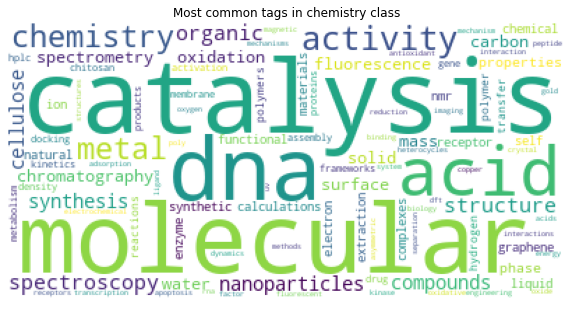

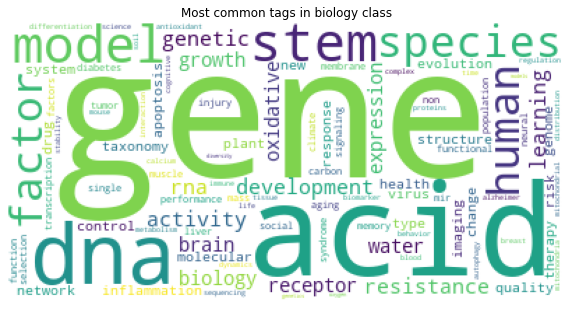

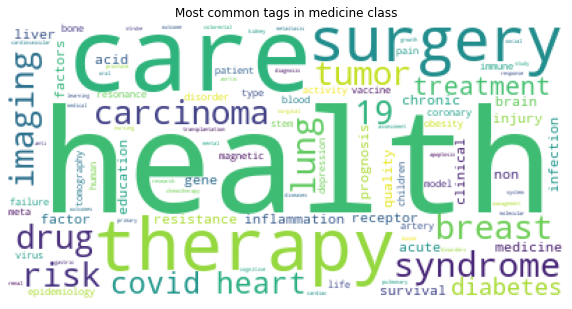

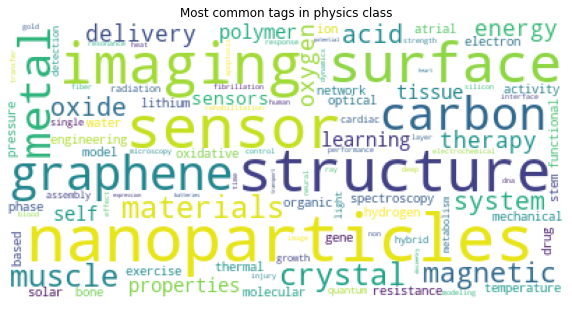

In [39]:
# Select the column you want to visualise and labels
test = df[['label', 'tags']].copy()

# initiate tf idf vectorizer
vectorizer = TfidfVectorizer(stop_words=tags_stop, min_df=4, max_df = 1000)

#fit on data columns
vectorizer.fit(test['tags'])

# make tf idf sparse matrix 
document_matrix = vectorizer.transform(test['tags'])

#setup empty df to be the output
final_df = {}

for i, label in enumerate(df['label'].unique()):
    mask = (df['label'] == label)
    masked = document_matrix[mask]
    sum_words = masked.sum(axis=0)
    # look through each word in the vectorizer and go into sum_words in the first (only) row and the column number corresponding to that word
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # sort by the second item in the tuple
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    final_df[label] = words_freq[:100] #top 100 words

#turn the dictionary into a dataframe of weights of top 100 words - each column has tuple of (word, weight)
final_df = pd.DataFrame(final_df)

#plot wordcloud for each unique label
for field in ['chemistry', 'biology', 'medicine', 'physics']:
    #intermediate dictionary to pair weights
    tags_freq_med = {}
    for i, j in final_df[field]:
        tags_freq_med[i] = int(j)

    dictionary = {None}
    cloud = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(tags_freq_med)
    
    plt.figure(figsize=(10,7))
    plt.imshow(cloud)
    plt.axis("off")
    plt.title(f'Most common tags in {field} class')
    plt.show()

## Visualising word abundance in abstract column

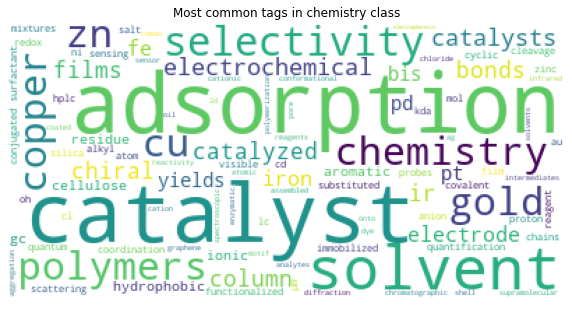

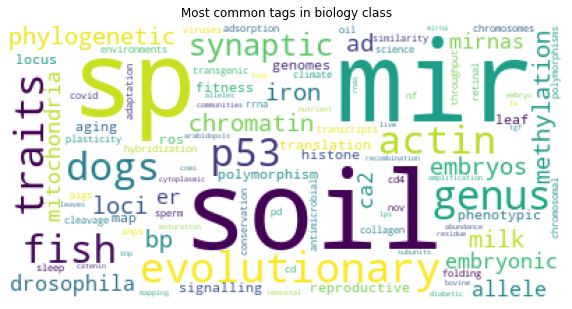

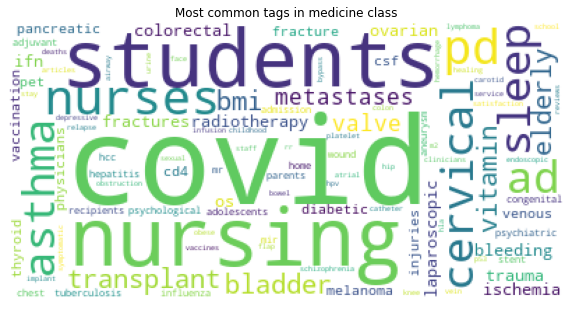

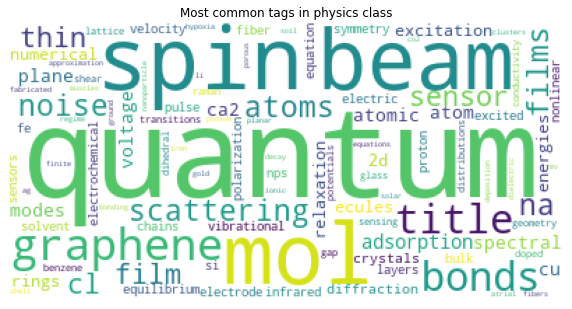

In [40]:
# Select the column you want to visualise and labels
test = df[['label', 'abstract']].copy()

# initiate tf idf vectorizer
vectorizer = TfidfVectorizer(stop_words=tags_stop, min_df=4, max_df = 1000)

#fit on data columns
vectorizer.fit(test['abstract'])

# make tf idf sparse matrix 
document_matrix = vectorizer.transform(test['abstract'])

#setup empty df to be the output
final_df = {}

for i, label in enumerate(df['label'].unique()):
    mask = (df['label'] == label)
    masked = document_matrix[mask]
    sum_words = masked.sum(axis=0)
    # look through each word in the vectorizer and go into sum_words in the first (only) row and the column number corresponding to that word
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # sort by the second item in the tuple
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    final_df[label] = words_freq[:100] #top 100 words

#turn the dictionary into a dataframe of weights of top 100 words - each column has tuple of (word, weight)
final_df = pd.DataFrame(final_df)

#plot wordcloud for each unique label
for field in ['chemistry', 'biology', 'medicine', 'physics']:
    #intermediate dictionary to pair weights
    tags_freq_med = {}
    for i, j in final_df[field]:
        tags_freq_med[i] = int(j)

    dictionary = {None}
    cloud = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(tags_freq_med)
    
    plt.figure(figsize=(10,7))
    plt.imshow(cloud)
    plt.axis("off")
    plt.title(f'Most common tags in {field} class')
    plt.show()

## Visualising word abundance in title column

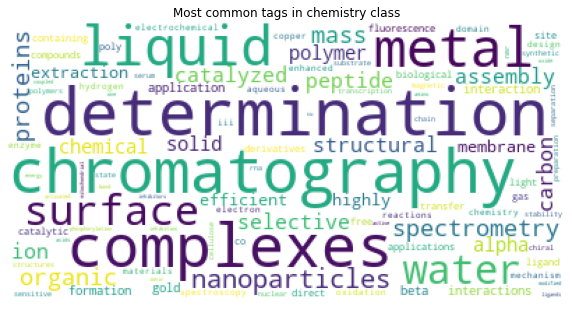

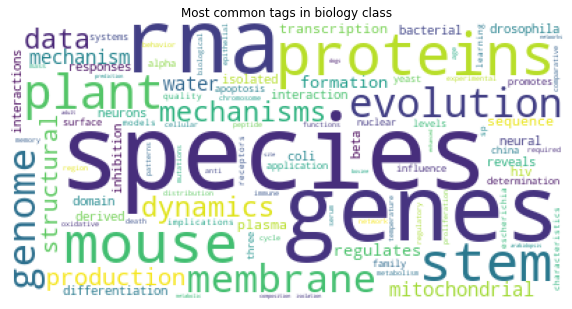

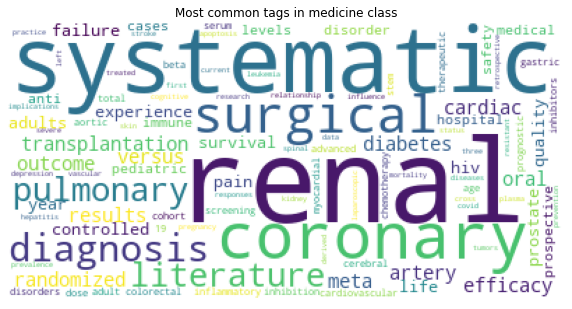

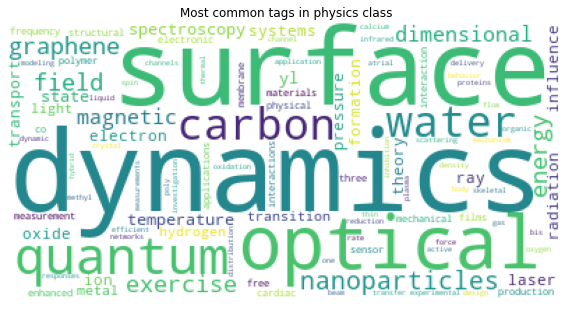

In [41]:
# Select the column you want to visualise and labels
test = df[['label', 'title']].copy()

# initiate tf idf vectorizer
vectorizer = TfidfVectorizer(stop_words=tags_stop, min_df=4, max_df = 1000)

#fit on data columns
vectorizer.fit(test['title'])

# make tf idf sparse matrix 
document_matrix = vectorizer.transform(test['title'])

#setup empty df to be the output
final_df = {}

for i, label in enumerate(df['label'].unique()):
    mask = (df['label'] == label)
    masked = document_matrix[mask]
    sum_words = masked.sum(axis=0)
    # look through each word in the vectorizer and go into sum_words in the first (only) row and the column number corresponding to that word
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    # sort by the second item in the tuple
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    final_df[label] = words_freq[:100] #top 100 words

#turn the dictionary into a dataframe of weights of top 100 words - each column has tuple of (word, weight)
final_df = pd.DataFrame(final_df)

#plot wordcloud for each unique label
for field in ['chemistry', 'biology', 'medicine', 'physics']:
    #intermediate dictionary to pair weights
    tags_freq_med = {}
    for i, j in final_df[field]:
        tags_freq_med[i] = int(j)

    dictionary = {None}
    cloud = WordCloud(background_color="white", max_words=1000).generate_from_frequencies(tags_freq_med)
    
    plt.figure(figsize=(10,7))
    plt.imshow(cloud)
    plt.axis("off")
    plt.title(f'Most common tags in {field} class')
    plt.show()

<br>

I am electing to NOT use stemming, as there is a) quite a lot of nuance that can get lost due to slight differences in words (e.g. evolutions occurs in chemistry but almost never in biology, while evolution occurs in biology highly frequently) and b) lots of short seeminly strange words but in reality these are acronyms/elements/compounds and thus some of these features will be absorbed into stems of words that have no shared root (e.g. complexes is a chemistry noun, complex is a biological adjective).

It should be clear from these wordclouds that there is a difference in corpus composition when comparing the different scientific domains. Therefore, I am led to my next question: Can you fit a classification model to this data and will it perform better than baseline?

I am choosing this as my metric of success - though baseline will vary depending on which subset of my data I use

---

<br>

# Modelling

---

<br>

I will be investigating the success of various models
    - Neighbors Classifier (K Nearest Neighbors)
    - Linear model Classifier (Logistic Regression)
    - Tree Classifier (Decision Tree Classifier)
    - Bagging Classifier (Random Forest Classifier)
    - Gradient-boosted Classifier (Gradient Boosting Classifier)
    
I also looked at various unsupervised clustering algorithms (rather naively) as I had hoped that articles from a scientific domain would cluster in vector space.
<br>

In [14]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

This function plots a confusion matrix  for my custom labels and and predictions, and is used later in diagnostics

In [15]:
# This function allows me to iterate exclude certain text cols as predictors

def feature_dict_pairer(feature):
    if feature == 'abstract':
        return int(ab_features)
    elif feature == 'tags':
        return int(tag_features)
    elif feature == 'title':
        return int(titl_features)
    else:
        pass

### Running a naive model

<br>
Just to get an idea of what I'm dealing with for training scores I already applied to vectorization to a df, now reading it in:

In [ ]:
#Read in the data with classes balanced
downsampled = pd.read_csv('downsampled_predictors')

In [ ]:
#Init logistic regression and scaler objects, c= 0.7 because I have lots of columns
logreg = LogisticRegression(penalty = 'l1', C = 0.7, solver='saga', max_iter = 1000, random_state=1, n_jobs = 4)
scaler = StandardScaler()

#setup x_train etc
X = downsampled
y = X.pop('label')

# Need to actually vectorize AFTER the split
print('Scaling data...')
X = scaler.fit_transform(X)

print('Fitting logistic regression...')
# LOGISTIC REGRESSION
logreg.fit(X, y)

In [10]:
lr_prediction = logreg.predict(X)
#started at 6 40 

In [11]:
logreg.score(X, y)

0.8625706214689266

In [14]:
lr_results = np.array(list(zip(y,lr_prediction)))
print(classification_report(y, lr_prediction))

                 precision    recall  f1-score   support

        biology       0.84      0.79      0.81      2832
      chemistry       0.89      0.92      0.90      2832
general_journal       0.82      0.85      0.84      2832
       medicine       0.88      0.88      0.88      2832
        physics       0.87      0.87      0.87      2832

       accuracy                           0.86     14160
      macro avg       0.86      0.86      0.86     14160
   weighted avg       0.86      0.86      0.86     14160



At first glance this would seem good, but need to see how much this has overfit and so I will run through a range of types of models and print the confusion matrix as well as accuracy of these models.

# Running through many models

<br>

Below is some code that can be added in to the for loop further below (that runs through many models) in order to see the effects of excluding some columns as predictors. Not too much to see, just wanted it to be present as it was used and is talked about briefly.

In [ ]:
# #setup list of vector cols to say which cols get vectorised (if features are 0, this col will be popped)
# tags_features = [0, 800, 1000, 1500, ]
# abs_features = [500, 1500 , 2200, 3000, 0]
# title_features = [500, 1200, 1800, 0]

# #setup list of vector cols to say which cols get vectorised (if features are 0, this col will be popped)

# possible_vect_cols = ['title', 'abstract', 'tags']
# action_cols = possible_vect_cols.copy()

# #to store results in
# res_dict = {}

# for tag_features in tags_features:
#     try:
#         if tag_features == 0:
#             action_cols.remove('tags') #this is just so the functions I wrote earlier for a different set of models dont break if features = 0
#     except:
#         pass
#     for ab_features in abs_features:
#         try:
#             if ab_features == 0:
#                 action_cols.remove('abstract')
#         except:
#             pass
#         for titl_features in title_features:
#             try:
#                 if titl_features == 0:
#                     action_cols.remove('title')

#### Setting the training set

In [8]:
dfbase = pd.read_csv('40ksubset.csv')
data = dfbase.copy()

In [9]:
#setting up df of predictors and label
df = data[['years', 'label', 'abstract', 'title', 'tags']]

X = df[['years', 'abstract', 'title', 'tags']]
y = df['label']

#dummy year columns
print('Getting dummies...')
X = pd.get_dummies(X, prefix = 'years', columns=['years'], drop_first=True) #maybe make this a sparse array

Getting dummies...


In [10]:
#train test split the data
print('Splitting for train test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, test_size=0.3, random_state=42)

Splitting for train test split...


In [13]:
#fit and transform xtrain
print('Transforming X_train to tfidf vectorise text columns...')
X_train, vector_dictionary = data_transformer(df = X_train, vect_cols = ['abstract', 'title', 'tags'], 
                                                  max_features = {'tags': 500, 'abstract': 1000, 'title': 300})

#transform xtest 
print('Transforming X_test using training tfidf vectors...')
X_test = test_vectoriser(X_test, vect_dict=vector_dictionary)

#filling the nans that arose because i ran out of float space - by all accounts these can be considered 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

Transforming X_train to tfidf vectorise text columns...
abs df shape : (24794, 1000)
title df shape : (24794, 300)
tags df shape : (24794, 500)
Transforming X_test using training tfidf vectors...


In [81]:
### Running through a LOT of models trying different numbers of features as outputs for tf-idf vectorization

#here I can change the n of features I want to investigate (iterate through)
tags_features = [100, 250, 500, 800, 1000, 1500, 2500]
abs_features = [100, 400, 800, 1500, 2200, 3000]
title_features = [100, 250, 500, 800, 1200, 1800]

#setup list of vector cols to say which cols get vectorised (if features are 0, this col will be popped)

possible_vect_cols = ['title', 'abstract', 'tags']
action_cols = possible_vect_cols.copy()

for tag_features in tags_features:
    if tag_features == 0:
        action_cols.pop('tags') #this is just so the functions I wrote earlier for a different set of models dont break if features = 0
        
    for ab_features in abs_features:
        if ab_features == 0:
        action_cols.pop('abstract')
        
        for titl_features in title_features:
            if titl_features == 0:
                action_cols.pop('title')
            
            
            print('-'*95)
            print('-'*95)
            print(f'|| Fitting models with: || TAG features: {tag_features} || ABSTRACT features: {ab_features} || TITLE features: {titl_features}||')
            print('-'*95)
            print('-'*95)
            
            #setup X and y
            df = data[['years', 'label', 'abstract', 'title', 'tags']]

            X = df[['years', 'abstract', 'title', 'tags']]
            y = df['label']

            #dummy year columns
            print('Getting dummies...')
            X = pd.get_dummies(X, prefix = 'years', columns=['years'], drop_first=True)

            print('Splitting for train test split...')
            X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                                stratify = y, test_size=0.3, random_state=42)

            #fit and tranform xtrain
            print('Transforming X_train to tfidf vectorise text columns...')
            # need to setup dictionary of features cols and the n features assocaited with them
            max_features_dict = dict(zip(action_cols, [feature_dict_pairer(x) for x in action_cols]))
            X_train, vector_dictionary = data_transformer(df = X_train, vect_cols = action_cols, 
                                                max_features = {'tags': tag_features, 'abstract': ab_features, 'title': titl_features})

            #transform xtest 
            print('Transforming X_test using training tfidf vectors...')
            X_test = test_vectoriser(X_test, vect_dict=vector_dictionary)
            
            #filling the nans that arose because i ran out of float space - by all accounts these can be considered 0
            X_train.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)
            
            # scale because why not
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # I tried this and the confusion matrices show the presence of the general journal category is not helpful
            y_test = ['biology' if x == 'general_journal' else x for x in y_test]
            y_train = ['biology' if x == 'general_journal' else x for x in y_train]

            # setup models
            models = [KNeighborsClassifier(n_neighbors = 10, n_jobs = 4),
                      DecisionTreeClassifier(max_depth = 300, min_samples_split = 3),
                      RandomForestClassifier(n_estimators=100, max_features= 300, n_jobs = 4),
                      LogisticRegression(penalty = 'l1', C = 0.7, solver='saga', max_iter = 1000, random_state=42, n_jobs = 4)
                     ]


            #setup results list to store the results of the models we iterate through below
            res = []

            print('Initialising model fitting...')
            for model in models:
                print(model)
                print() #below we are just fiting and predicting labels 
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                print(score)
                print()
                #printing the confusion matrix
                cm = docm(y_test, y_pred, ['biology', 'chemistry', 'medicine', 'physics'])
                print(cm)
                res.append([model, score])
                print('\n', '-'*60, '\n')

    
#This will give me an output of the relative scores of these models - need to consider after which one needs gridsearching

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 100 || ABSTRACT features: 100 || TITLE features: 100||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape : (82939, 100)
tags df shape : (82939, 100)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4761154560288077

           p_biology  p_chemistry  p_medicine  p_physics
biology         2136           95        7367        138
chemistry        429           20        1610         32
med

Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4696168345242784

           p_biology  p_chemistry  p_medicine  p_physics
biology         2156          212        7222        146
chemistry        461           33        1563         34
medicine        4284          552       14422        278
physics          945           87        3069         82

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.42030045574748215

           p_biology  p_chemistry  p_medicine  p_physics
biology         2505          429        5930        872
chemistry        520          102        1292        177
medicine        5029          857       11898       1752
physics         1087          203        2458        435

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5445619760310584

 

0.5409891408315985

           p_biology  p_chemistry  p_medicine  p_physics
biology          367            1        9354         14
chemistry         66            0        2024          1
medicine         683            0       18847          6
physics          162            0        4005         16

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5483880042761492

           p_biology  p_chemistry  p_medicine  p_physics
biology           81            0        9630         25
chemistry         17            0        2071          3
medicine         140            0       19382         14
physics           41            0        4112         30

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
---------------------------------------------------

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape : (82939, 1200)
tags df shape : (82939, 100)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46784448320486133

           p_biology  p_chemistry  p_medicine  p_physics
biology         2192          224        7093        227
chemistry        480           31        1533         47
medicine        4252          553       14283        448
physics          919           94        3046        124

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.4172340066392843

           p_biology  p_chemistry  p_medicine  p_physics
biology         2786          413        5620        917
chemistry        576           97        1227        191
medicine        5358          778       11558       1842
physics         1089          179        2525    

0.4098070106341079

           p_biology  p_chemistry  p_medicine  p_physics
biology         2985          471        5354        926
chemistry        584           98        1208        201
medicine        5693          930       11070       1843
physics         1188          198        2383        414

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5424520339841332

           p_biology  p_chemistry  p_medicine  p_physics
biology          322            0        9405          9
chemistry         46            0        2044          1
medicine         585            0       18944          7
physics          120            0        4047         16

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.545434085410454

           p_biology  p_chemistry  p_medicine  p_physics
biology          12

0.5360940752827322

           p_biology  p_chemistry  p_medicine  p_physics
biology          331            0        9366         39
chemistry         63            0        2022          6
medicine         828            0       18689         19
physics          130            0        4017         36

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 100 || ABSTRACT features: 800 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shape : (82939, 500)
tags df shape : (82939, 100)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46896978562988806

           p_biology  p_chemistry  p_medicine  p_physics
biology         2139          223        7230        144
chemistry        479           32        1552         28
medicine        4288          542       14394        312
physics          926           87        3065        105

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3649355764361672

           p_biology  p_chemistry  p_medicine  p_physics
biology         3905          327        4564        940
chemistry        803           92        1017        179
medicine        8477          645        8551       1863
physics         1646          167        1946    

0.33010746638159005

           p_biology  p_chemistry  p_medicine  p_physics
biology         3551          511        3971       1703
chemistry        699          138         917        337
medicine        7650         1176        7339       3371
physics         1508          254        1715        706

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5293141281719462

           p_biology  p_chemistry  p_medicine  p_physics
biology          842            1        8882         11
chemistry        179            0        1909          3
medicine        1556            1       17964         15
physics          343            0        3831          9

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5426489619085129

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5409891408315985

           p_biology  p_chemistry  p_medicine  p_physics
biology          333            0        9374         29
chemistry         74            0        2015          2
medicine         654            0       18868         14
physics          150            0        4004         29

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 100 || ABSTRACT features: 2200 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shap

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shape : (82939, 100)
tags df shape : (82939, 100)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.47110786023743884

           p_biology  p_chemistry  p_medicine  p_physics
biology         2172          190        7234        140
chemistry        445           25        1583         38
medicine        4318          490       14463        265
physics          911           87        3099         86

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3574241827491138

           p_biology  p_chemistry  p_medicine  p_physics
biology         2527          814        4433       1962
chemistry        576          193        1012        310
medicine        5272         1223        9293       3748
physics         1186          320        1985    

0.39138018342429526

           p_biology  p_chemistry  p_medicine  p_physics
biology         3087          322        4780       1547
chemistry        672          103        1073        243
medicine        6306          618       10163       2449
physics         1411          172        2041        559

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5165700782085185

           p_biology  p_chemistry  p_medicine  p_physics
biology         1097            0        8610         29
chemistry        220            0        1866          5
medicine        2258            1       17244         33
physics          477            0        3685         21

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5337872053114274

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5483598717155236

           p_biology  p_chemistry  p_medicine  p_physics
biology           81            1        9630         24
chemistry         15            0        2073          3
medicine         141            1       19383         11
physics           43            2        4110         28

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 250 || ABSTRACT features: 100 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape 

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape : (82939, 1200)
tags df shape : (82939, 250)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4635402014291341

           p_biology  p_chemistry  p_medicine  p_physics
biology         2105          213        7260        158
chemistry        464           33        1565         29
medicine        4404          541       14240        351
physics          947           85        3052         99

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.42769931919203286

           p_biology  p_chemistry  p_medicine  p_physics
biology         2398          417        6129        792
chemistry        492           78        1360        161
medicine        4807          853       12365       1511
physics         1013          181        2627    

0.3893265064986215

           p_biology  p_chemistry  p_medicine  p_physics
biology         3023          447        5280        986
chemistry        616          122        1166        187
medicine        6178         1125       10283       1950
physics         1281          237        2254        411

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5423957688628819

           p_biology  p_chemistry  p_medicine  p_physics
biology          358            0        9364         14
chemistry         69            0        2021          1
medicine         619            0       18907         10
physics          144            0        4024         15

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5463905924717267

           p_biology  p_chemistry  p_medicine  p_physics
biology          1

0.5380914870871547

           p_biology  p_chemistry  p_medicine  p_physics
biology          312            2        9395         27
chemistry         64            0        2023          4
medicine         724            1       18784         27
physics          156            1        3995         31

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 250 || ABSTRACT features: 400 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape : (82939, 500)
tags df shape : (82939, 250)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4657908062791875

           p_biology  p_chemistry  p_medicine  p_physics
biology         2153          219        7194        170
chemistry        487           28        1539         37
medicine        4434          542       14273        287
physics          924           91        3065        103

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.40702188713216675

           p_biology  p_chemistry  p_medicine  p_physics
biology         2874          465        5510        887
chemistry        609          104        1203        175
medicine        5736         1001       11124       1675
physics         1216          199        2402     

0.42117256512687784

           p_biology  p_chemistry  p_medicine  p_physics
biology         2635          429        5787        885
chemistry        537           82        1303        169
medicine        5219          835       11878       1604
physics         1058          191        2558        376

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5450402295616947

           p_biology  p_chemistry  p_medicine  p_physics
biology          199            0        9527         10
chemistry         34            0        2056          1
medicine         370            0       19160          6
physics           77            0        4091         15

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.543070950317898

           p_biology  p_chemistry  p_medicine  p_physics
biology          4

0.5443087829854273

           p_biology  p_chemistry  p_medicine  p_physics
biology          351            0        9360         25
chemistry         83            0        2005          3
medicine         546            2       18968         20
physics          148            1        4005         29

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 250 || ABSTRACT features: 1500 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shap

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shape : (82939, 100)
tags df shape : (82939, 250)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46880099026613403

           p_biology  p_chemistry  p_medicine  p_physics
biology         2089          188        7319        140
chemistry        493           27        1538         33
medicine        4374          460       14463        239
physics          894           77        3127         85

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3651043717999212

           p_biology  p_chemistry  p_medicine  p_physics
biology         3464          302        5016        954
chemistry        613           37        1218        223
medicine        8125          660        9103       1

0.38777921566420975

           p_biology  p_chemistry  p_medicine  p_physics
biology         3451          263        5424        598
chemistry        635           44        1264        148
medicine        7521          907       10002       1106
physics         1349          120        2427        287

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5132223034940641

           p_biology  p_chemistry  p_medicine  p_physics
biology         1086            0        8627         23
chemistry        192            0        1894          5
medicine        2371            2       17136         27
physics          422            0        3740         21

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5358127496764755

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5409610082709728

           p_biology  p_chemistry  p_medicine  p_physics
biology          282            2        9419         33
chemistry         69            0        2018          4
medicine         603            0       18914         19
physics          147            1        4002         33

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 250 || ABSTRACT features: 3000 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shap

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shape : (82939, 1200)
tags df shape : (82939, 250)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46806954368986664

           p_biology  p_chemistry  p_medicine  p_physics
biology         2113          214        7164        245
chemistry        468           30        1535         58
medicine        4171          548       14370        447
physics          967           85        3006        125

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.380042761492151

           p_biology  p_chemistry  p_medicine  p_physics
biology         2742          347        4992       1655
chemistry        656           72        1108        255
medicine        5616          625       10081       3

0.40775333370843414

           p_biology  p_chemistry  p_medicine  p_physics
biology         2731          436        5628        941
chemistry        553          122        1223        193
medicine        5420         1032       11187       1897
physics         1103          199        2427        454

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5385697406177911

           p_biology  p_chemistry  p_medicine  p_physics
biology          291            9        9414         22
chemistry         65            1        2019          6
medicine         660           14       18822         40
physics          141            5        4007         30

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5461655319867215

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5376132335565184

           p_biology  p_chemistry  p_medicine  p_physics
biology          254            0        9455         27
chemistry         45            0        2043          3
medicine         696            1       18821         18
physics          120            1        4027         35

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 500 || ABSTRACT features: 100 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape

Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape : (82939, 500)
tags df shape : (82939, 500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46708490406796827

           p_biology  p_chemistry  p_medicine  p_physics
biology         2112          224        7248        152
chemistry        470           31        1558         32
medicine        4349          545       14364        278
physics          937           88        3062         96

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.40887863613346087

           p_biology  p_chemistry  p_medicine  p_physics
biology         2779          493        5503        961
chemistry        593          115        1130        253
medicine        5469          904       11231       1932
physics        

0.41461767850109715

           p_biology  p_chemistry  p_medicine  p_physics
biology         2758          366        5818        794
chemistry        614           68        1238        171
medicine        5517          784       11587       1648
physics         1174          180        2504        325

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5461936645473471

           p_biology  p_chemistry  p_medicine  p_physics
biology          189            0        9530         17
chemistry         43            0        2048          0
medicine         317            0       19212          7
physics           81            0        4088         14

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5413829966803578

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5437742643335396

           p_biology  p_chemistry  p_medicine  p_physics
biology          238            0        9467         31
chemistry         39            0        2049          3
medicine         451            1       19065         19
physics          111            1        4045         26

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 500 || ABSTRACT features: 800 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape 

Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shape : (82939, 100)
tags df shape : (82939, 500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4701513531761661

           p_biology  p_chemistry  p_medicine  p_physics
biology         2115          182        7303        136
chemistry        471           23        1568         29
medicine        4328          462       14498        248
physics          908           82        3117         76

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.32543746131772916

           p_biology  p_chemistry  p_medicine  p_physics
biology         4049          416        3541       1730
chemistry        864          126         764        337
medicine        8210         1055        6694       3577
physics        

0.3399538626005739

           p_biology  p_chemistry  p_medicine  p_physics
biology         3751          477        4106       1402
chemistry        736          133         922        300
medicine        8665         1103        7624       2144
physics         1622          240        1745        576

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.524250267259326

           p_biology  p_chemistry  p_medicine  p_physics
biology         1102            1        8615         18
chemistry        220            0        1869          2
medicine        1996            1       17522         17
physics          456            0        3716         11

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5375007033140157

           p_biology  p_chemistry  p_medicine  p_physics
biology          41

0.5410172733922242

           p_biology  p_chemistry  p_medicine  p_physics
biology          307            0        9403         26
chemistry         42            0        2047          2
medicine         621            0       18900         15
physics          136            0        4023         24

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 500 || ABSTRACT features: 2200 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shap

Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shape : (82939, 1200)
tags df shape : (82939, 500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46559387835480787

           p_biology  p_chemistry  p_medicine  p_physics
biology         2134          225        7152        225
chemistry        468           30        1543         50
medicine        4264          533       14263        476
physics          931           86        3043        123

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.41481460642547685

           p_biology  p_chemistry  p_medicine  p_physics
biology         3372          537        5003        824
chemistry        651          117        1168        155
medicine        6235          726       10966       1609
physics      

0.34076970685871827

           p_biology  p_chemistry  p_medicine  p_physics
biology         2409          907        4434       1986
chemistry        575          189        1012        315
medicine        5259         1736        8816       3725
physics         1164          355        1965        699

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5169920666179035

           p_biology  p_chemistry  p_medicine  p_physics
biology         1157            3        8551         25
chemistry        224            1        1861          5
medicine        2299            4       17204         29
physics          482            1        3685         15

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5373037753896359

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5268384628368874

           p_biology  p_chemistry  p_medicine  p_physics
biology          448            1        9246         41
chemistry         86            0        1999          6
medicine        1260            2       18245         29
physics          255            0        3894         34

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 500 || ABSTRACT features: 3000 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df sha

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape : (82939, 500)
tags df shape : (82939, 800)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4688572553873854

           p_biology  p_chemistry  p_medicine  p_physics
biology         2133          217        7259        127
chemistry        450           32        1574         35
medicine        4351          507       14429        249
physics          901           87        3123         72

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.4204973836718618

           p_biology  p_chemistry  p_medicine  p_physics
biology         2666          409        5830        831
chemistry        539           76        1296        180
medicine        5101          847       11804       1784
physics         1017          172        2593      

0.4469138580993642

           p_biology  p_chemistry  p_medicine  p_physics
biology         2048          293        6692        703
chemistry        438           74        1431        148
medicine        4116          600       13447       1373
physics          849          160        2857        317

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5464187250323524

           p_biology  p_chemistry  p_medicine  p_physics
biology          122            0        9594         20
chemistry         36            0        2052          3
medicine         235            4       19282         15
physics           67            0        4097         19

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5440555899397963

           p_biology  p_chemistry  p_medicine  p_physics
biology          3

0.5447026388341867

           p_biology  p_chemistry  p_medicine  p_physics
biology          247            0        9458         31
chemistry         54            0        2034          3
medicine         420            3       19088         25
physics          103            0        4053         27

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 800 || ABSTRACT features: 400 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape 

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape : (82939, 100)
tags df shape : (82939, 800)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.47088279975243347

           p_biology  p_chemistry  p_medicine  p_physics
biology         2116          175        7294        151
chemistry        446           27        1572         46
medicine        4322          460       14509        245
physics          910           85        3102         86

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.4063748382377764

           p_biology  p_chemistry  p_medicine  p_physics
biology         3081          475        5188        992
chemistry        616           88        1183        204
medicine        5891          931       10806       19

0.4168964159117763

           p_biology  p_chemistry  p_medicine  p_physics
biology         2727          406        5729        874
chemistry        563           91        1238        199
medicine        5353          866       11638       1679
physics         1124          178        2518        363

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.544505710909807

           p_biology  p_chemistry  p_medicine  p_physics
biology          227            0        9502          7
chemistry         39            0        2051          1
medicine         415            0       19113          8
physics           86            0        4082         15

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5409047431497215

           p_biology  p_chemistry  p_medicine  p_physics
biology          32

0.5449839644404434

           p_biology  p_chemistry  p_medicine  p_physics
biology          324            0        9389         23
chemistry         51            0        2037          3
medicine         495            0       19027         14
physics          117            0        4045         21

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 800 || ABSTRACT features: 1500 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shap

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shape : (82939, 1200)
tags df shape : (82939, 800)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.468294604174872

           p_biology  p_chemistry  p_medicine  p_physics
biology         2141          227        7149        219
chemistry        445           33        1554         59
medicine        4160          551       14331        494
physics          936           89        3017        141

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.32903842907781466

           p_biology  p_chemistry  p_medicine  p_physics
biology         3861          520        3578       1777
chemistry        848          142         762        339
medicine        7844         1234        6952       3

0.37267203060822596

           p_biology  p_chemistry  p_medicine  p_physics
biology         3286          327        5251        872
chemistry        570           45        1288        188
medicine        7763          635        9595       1543
physics         1371          122        2369        321

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5213526135148822

           p_biology  p_chemistry  p_medicine  p_physics
biology         1073            0        8651         12
chemistry        186            0        1902          3
medicine        2079            1       17442         14
physics          379            0        3787         17

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5432397456816519

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.530608225960727

           p_biology  p_chemistry  p_medicine  p_physics
biology          602            0        9107         27
chemistry        101            0        1986          4
medicine        1293            3       18216         24
physics          214            0        3926         43

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 800 || ABSTRACT features: 2200 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shap

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shape : (82939, 500)
tags df shape : (82939, 800)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46843526697800036

           p_biology  p_chemistry  p_medicine  p_physics
biology         2235          211        7138        152
chemistry        439           32        1590         30
medicine        4393          543       14304        296
physics          948           91        3064         80

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3732346818207393

           p_biology  p_chemistry  p_medicine  p_physics
biology         2580         1343        5142        671
chemistry        559          306        1082        144
medicine        5964         2068       10045       1

0.35739605018848813

           p_biology  p_chemistry  p_medicine  p_physics
biology         2554          814        4383       1985
chemistry        590          198         981        322
medicine        5379         1264        9266       3627
physics         1236          326        1935        686

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5057109098070106

           p_biology  p_chemistry  p_medicine  p_physics
biology         1301            3        8399         33
chemistry        279            2        1805          5
medicine        2827            4       16650         55
physics          580            0        3580         23

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5341529285995611

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5429865526360209

           p_biology  p_chemistry  p_medicine  p_physics
biology          151            0        9554         31
chemistry         31            0        2056          4
medicine         398            1       19123         14
physics           78            0        4078         27

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1000 || ABSTRACT features: 100 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape : (82939, 100)
tags df shape : (82939, 1000)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.47048894390367413

           p_biology  p_chemistry  p_medicine  p_physics
biology         2150          186        7274        126
chemistry        469           27        1564         31
medicine        4387          439       14460        250
physics          922           78        3096         87

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3905643391661509

           p_biology  p_chemistry  p_medicine  p_physics
biology         2908          455        5224       1149
chemistry        650           87        1134        220
medicine        6080          969       10415       2

0.4091880943003432

           p_biology  p_chemistry  p_medicine  p_physics
biology         2900          400        5518        918
chemistry        582           91        1250        168
medicine        5616          951       11174       1795
physics         1232          169        2402        380

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5441399876216734

           p_biology  p_chemistry  p_medicine  p_physics
biology          202            0        9524         10
chemistry         45            0        2045          1
medicine         404            0       19126          6
physics          109            0        4060         14

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.539244922072807

           p_biology  p_chemistry  p_medicine  p_physics
biology          26

0.543746131772914

           p_biology  p_chemistry  p_medicine  p_physics
biology          185            0        9521         30
chemistry         33            0        2055          3
medicine         412            0       19115          9
physics           73            0        4082         28

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1000 || ABSTRACT features: 800 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape 

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape : (82939, 1200)
tags df shape : (82939, 1000)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46539695043042817

           p_biology  p_chemistry  p_medicine  p_physics
biology         2205          222        7071        238
chemistry        470           35        1526         60
medicine        4382          550       14169        435
physics          934           92        3023        134

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.42558937714510775

           p_biology  p_chemistry  p_medicine  p_physics
biology         2682          393        5761        900
chemistry        549           89        1276        177
medicine        5241          804       11997      

0.34079783941934394

           p_biology  p_chemistry  p_medicine  p_physics
biology         3637          246        4150       1703
chemistry        737           43         970        341
medicine        7654          827        7717       3338
physics         1564           86        1816        717

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5241658695774489

           p_biology  p_chemistry  p_medicine  p_physics
biology          962            1        8758         15
chemistry        194            0        1894          3
medicine        1862            1       17661         12
physics          370            0        3804          9

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5407922129072188

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5326619028864007

           p_biology  p_chemistry  p_medicine  p_physics
biology          575            0        9128         33
chemistry        111            0        1977          3
medicine        1180            1       18327         28
physics          232            0        3919         32

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1000 || ABSTRACT features: 1500 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df sh

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shape : (82939, 500)
tags df shape : (82939, 1000)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4668598435829629

           p_biology  p_chemistry  p_medicine  p_physics
biology         2149          229        7205        153
chemistry        498           33        1523         37
medicine        4387          550       14313        286
physics          949           94        3040        100

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3746413098520227

           p_biology  p_chemistry  p_medicine  p_physics
biology         3578          494        4930        734
chemistry        722           95        1132        142
medicine        7822          908        9352       1

0.38389692229786754

           p_biology  p_chemistry  p_medicine  p_physics
biology         3491          448        5101        696
chemistry        699           96        1157        139
medicine        7642          717        9789       1388
physics         1421          186        2306        270

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5009846396218984

           p_biology  p_chemistry  p_medicine  p_physics
biology         1319            2        8389         26
chemistry        210            1        1874          6
medicine        3030            3       16472         31
physics          480            0        3687         16

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5343779890845665

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5361503404039836

           p_biology  p_chemistry  p_medicine  p_physics
biology          371            1        9324         40
chemistry         97            0        1989          5
medicine         857            1       18652         26
physics          199            0        3949         35

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1000 || ABSTRACT features: 3000 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df sha

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape : (82939, 100)
tags df shape : (82939, 1500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4774658189388398

           p_biology  p_chemistry  p_medicine  p_physics
biology         2107          101        7409        119
chemistry        414           15        1632         30
medicine        4272          262       14764        238
physics          869           43        3185         86

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.4052495358127497

           p_biology  p_chemistry  p_medicine  p_physics
biology         2803          528        5376       1029
chemistry        562          114        1251        164
medicine        5491          994       11042       20

0.4327913126652788

           p_biology  p_chemistry  p_medicine  p_physics
biology         2434          387        6202        713
chemistry        508           63        1344        176
medicine        4705          827       12561       1443
physics         1026          172        2659        326

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.544758903955438

           p_biology  p_chemistry  p_medicine  p_physics
biology          206            0        9515         15
chemistry         39            0        2049          3
medicine         373            5       19141         17
physics           90            3        4073         17

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5405952849828392

           p_biology  p_chemistry  p_medicine  p_physics
biology          25

0.5443931806673044

           p_biology  p_chemistry  p_medicine  p_physics
biology          199            0        9513         24
chemistry         24            0        2064          3
medicine         400            0       19122         14
physics           73            0        4080         30

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1500 || ABSTRACT features: 400 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape

Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape : (82939, 1200)
tags df shape : (82939, 1500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46688797614358857

           p_biology  p_chemistry  p_medicine  p_physics
biology         2146          222        7144        224
chemistry        473           31        1537         50
medicine        4283          547       14288        418
physics          932           90        3030        131

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.411916952681033

           p_biology  p_chemistry  p_medicine  p_physics
biology         2881          483        5506        866
chemistry        589          125        1184        193
medicine        5621          850       11232       1833
physics         1119          245        2415    

0.411832554999156

           p_biology  p_chemistry  p_medicine  p_physics
biology         3038          500        5330        868
chemistry        555          116        1252        168
medicine        5839          914       11089       1694
physics         1155          228        2404        396

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5447026388341867

           p_biology  p_chemistry  p_medicine  p_physics
biology          295            0        9433          8
chemistry         54            1        2035          1
medicine         473            0       19057          6
physics           90            0        4084          9

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5420019130141226

           p_biology  p_chemistry  p_medicine  p_physics
biology          23

0.5319304563101334

           p_biology  p_chemistry  p_medicine  p_physics
biology          431            0        9266         39
chemistry         74            2        2009          6
medicine        1071            2       18442         21
physics          175            0        3975         33

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1500 || ABSTRACT features: 800 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shap

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df shape : (82939, 500)
tags df shape : (82939, 1500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46911044843301636

           p_biology  p_chemistry  p_medicine  p_physics
biology         2159          217        7196        164
chemistry        499           34        1529         29
medicine        4329          538       14394        275
physics          947           89        3059         88

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3525853823214989

           p_biology  p_chemistry  p_medicine  p_physics
biology         3771          329        4428       1208
chemistry        786           50        1052        203
medicine        8359          759        8241       

0.3339616271873066

           p_biology  p_chemistry  p_medicine  p_physics
biology         3736          527        3741       1732
chemistry        793          153         793        352
medicine        7663         1226        7254       3393
physics         1614          280        1561        728

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5302143701119676

           p_biology  p_chemistry  p_medicine  p_physics
biology          911            2        8805         18
chemistry        192            0        1895          4
medicine        1596            1       17924         15
physics          365            0        3806         12

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5407078152253418

           p_biology  p_chemistry  p_medicine  p_physics
biology          6

0.5384572103752884

           p_biology  p_chemistry  p_medicine  p_physics
biology          441            0        9266         29
chemistry         76            0        2012          3
medicine         852            0       18671         13
physics          177            0        3978         28

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 1500 || ABSTRACT features: 2200 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df sha

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shape : (82939, 100)
tags df shape : (82939, 1500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.46761942271985596

           p_biology  p_chemistry  p_medicine  p_physics
biology         2088          195        7335        118
chemistry        456           25        1575         35
medicine        4415          456       14423        242
physics          963           83        3051         86

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3594778596747876

           p_biology  p_chemistry  p_medicine  p_physics
biology         2643          872        4501       1720
chemistry        603          207        1011        270
medicine        5462         1350        9300       

0.385641141056659

           p_biology  p_chemistry  p_medicine  p_physics
biology         3036          259        4746       1695
chemistry        640           79        1055        317
medicine        6476          419        9954       2687
physics         1408          132        2004        639

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5108591684015079

           p_biology  p_chemistry  p_medicine  p_physics
biology         1244            0        8456         36
chemistry        256            0        1825         10
medicine        2594            1       16887         54
physics          558            0        3597         28

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5297923817025826

           p_biology  p_chemistry  p_medicine  p_physics
biology          43

0.5474314972148765

           p_biology  p_chemistry  p_medicine  p_physics
biology          132            1        9579         24
chemistry         15            0        2073          3
medicine         226            0       19300         10
physics           71            0        4085         27

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 2500 || ABSTRACT features: 100 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 100)
title df shape : (82939, 1200)
tags df shape : (82939, 2500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4666347830979576

           p_biology  p_chemistry  p_medicine  p_physics
biology         2132          223        7218        163
chemistry        440           32        1595         24
medicine        4374          546       14314        302
physics          881           90        3103        109

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.44421313227930004

           p_biology  p_chemistry  p_medicine  p_physics
biology         2209          365        6466        696
chemistry        437           74        1437        143
medicine        4164          805       13158       

0.3999324818544984

           p_biology  p_chemistry  p_medicine  p_physics
biology         2888          485        5443        920
chemistry        608          124        1160        199
medicine        5793         1014       10801       1928
physics         1195          213        2372        403

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5442525178641759

           p_biology  p_chemistry  p_medicine  p_physics
biology          221            0        9502         13
chemistry         52            0        2038          1
medicine         417            0       19110          9
physics           92            0        4076         15

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5464468575929781

           p_biology  p_chemistry  p_medicine  p_physics
biology          1

0.537894559162775

           p_biology  p_chemistry  p_medicine  p_physics
biology          339            1        9364         32
chemistry         66            0        2020          5
medicine         763            0       18750         23
physics          170            0        3982         31

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 2500 || ABSTRACT features: 400 || TITLE features: 1800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 800)
title df shape : (82939, 500)
tags df shape : (82939, 2500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4668598435829629

           p_biology  p_chemistry  p_medicine  p_physics
biology         2133          222        7216        165
chemistry        465           34        1560         32
medicine        4375          537       14348        276
physics          971           88        3044         80

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.41394249704608116

           p_biology  p_chemistry  p_medicine  p_physics
biology         2753          458        5594        931
chemistry        611           96        1206        178
medicine        5443          853       11486       1

0.42778371687390987

           p_biology  p_chemistry  p_medicine  p_physics
biology         2691          388        5843        814
chemistry        532          103        1284        172
medicine        5178          738       12069       1551
physics         1082          176        2582        343

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5463061947898498

           p_biology  p_chemistry  p_medicine  p_physics
biology          171            0        9556          9
chemistry         29            0        2062          0
medicine         295            0       19235          6
physics           60            0        4110         13

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5418049850897428

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5439711922579193

           p_biology  p_chemistry  p_medicine  p_physics
biology          389            2        9318         27
chemistry         83            0        2006          2
medicine         601            0       18920         15
physics          166            0        3990         27

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 2500 || ABSTRACT features: 1500 || TITLE features: 800||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 1500)
title df sha

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 2200)
title df shape : (82939, 100)
tags df shape : (82939, 2500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4708265346311821

           p_biology  p_chemistry  p_medicine  p_physics
biology         2117          189        7292        138
chemistry        477           24        1557         33
medicine        4344          444       14505        243
physics          864           88        3141         90

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.42302931412817196

           p_biology  p_chemistry  p_medicine  p_physics
biology         2950          285        5684        817
chemistry        536           55        1316        184
medicine        5842          648       11743       

0.38009902661340234

           p_biology  p_chemistry  p_medicine  p_physics
biology         3386          222        5112       1016
chemistry        640           38        1167        246
medicine        7497          683        9716       1640
physics         1338           96        2378        371

------------------------------------------------------------

RandomForestClassifier(max_features=300, n_jobs=4)

0.5260507511393687

           p_biology  p_chemistry  p_medicine  p_physics
biology          870            1        8851         14
chemistry        163            0        1927          1
medicine        1694            3       17822         17
physics          322            0        3854          7

------------------------------------------------------------

LogisticRegression(C=0.7, max_iter=1000, n_jobs=4, penalty='l1',
                   random_state=42, solver='saga')

0.5360096776008553

           p_biology  p_chemistry  p_medicine  p_physics
biology          

0.5397513081640691

           p_biology  p_chemistry  p_medicine  p_physics
biology          314            0        9388         34
chemistry         62            0        2025          4
medicine         681            0       18836         19
physics          175            0        3972         36

------------------------------------------------------------

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 2500 || ABSTRACT features: 3000 || TITLE features: 250||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df sha

Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 3000)
title df shape : (82939, 1200)
tags df shape : (82939, 2500)
Transforming X_test using training tfidf vectors...
Initialising model fitting...
KNeighborsClassifier(n_jobs=4, n_neighbors=10)

0.4673943622348506

           p_biology  p_chemistry  p_medicine  p_physics
biology         2128          224        7181        203
chemistry        482           31        1533         45
medicine        4236          540       14328        432
physics          951           87        3018        127

------------------------------------------------------------

DecisionTreeClassifier(max_depth=300, min_samples_split=3)

0.3845439711922579

           p_biology  p_chemistry  p_medicine  p_physics
biology         3033          272        4706       1725
chemistry        630           69        1063        329
medicine        6431          528        9888       

<br>
Remember: Baseline accuracy for these models is 0.549589

These results are actually quite disappointing: none of these models which were fit on the complete dataset actually manage to achieve higher than baseline accuracy. There are 5 models which have an accuracy of 0.548, all of which are Logistic Regressions. In all of these, there are only ever 100 TF-IDF features in the title column.

I am going to highlight one model - with 100 title features, 400 abstract features, and 800 tags features. This fits quite nicely with my idea of the importance of the columns, and 400 seems to me like an appropriate number of words to think that we are considering most of the important discriminatory words.

In terms of performance, certain models acted quite differently which I will comment on:

**Neighbors model**: For this I ran a KNearestNeighbors classification model. The confusion matrices that came out of this seemed to have what I would call arbitrary assignment, though there was always noticeable recall in the medicine category; there was also almost always twice as many medical articles that were predicted as biology as there were biology articles (and this was the typically the next highest recall class in this model). Overall, the accuracy of the neighbors classifiers I ran was a little lower than the others, leading me to believe this is not the most suitable model type for my problem.

**Logistic regression**: I know earlier I called this a linear model, there I was using the root for the class in sklearn, but I performed multi-variate Logistic regressions so I will call it by its correct name. These were some of the more successful models (though that is not saying much). I specifically wanted to apply lasso regularization due to the large number of columns that NLP generates and have initially chosen quite a high regularization strength. I am not going to go into too much detail here as I investigate Logisitic Regression models further, as my best performing models. I will say that it is my understanding that while logisitic regression is not classification, it can be used to model classification, as classes can be assigned based on the multivariate log-likelihoods that logistic regression generates.

**Decision Tree Classifier**: Decision Trees seemed to be almost as good as Logistic Regressions. They suffered from the problem that a baseline score can be achieved by predicting everything as the majority class. This is obviously appealing if models are struggling to even achieve baseline accuracy but not appealing to me. These models seemed to be the best at recalling the lower proportioned classes- chemistry and physics, though when this happened it tended to be because the predictions appeared to be more random (i.e. yes these recalled the most chemistry but the precision in this case is about 0.07...). This is obviously not ideal either.

**Bagging Classifier**: There isn't actually too much to add here, I chose a Random Forest as my bagging classifier and used essentially the same parameters for the trees and I did for my decision tree models. What is interesting is that these models seem the most inclined to learn that they can increase their accuracy simply by predicting everything as 'medicine'. It is also interesting that these models also seem intent on misclassifying enough rows that they don't ever technically outperform Logistic Regression. I suspect that these models overfit on the lower proportion classes and the absolute number of the larger class rows that get misclassed because of this ensure these models don't achieve results above baseline.

<br>
In a different notebook I tried to exclude some of the predictor columns from the machine learning, and this also did not improve the results of the models. Funnily enough, the best performing models were still Logistic Regressions, but the best actually only used years and the top 400 features in the abstract column (neither of the other predictors), which is interesting but the confusion matrix revealed that it achieved this score simply by predicting almost all rows as 'medicine'

In [47]:
# Remember baseline
df.label.value_counts(normalize=True)

medicine     0.549589
biology      0.273908
physics      0.117686
chemistry    0.058818
Name: label, dtype: float64

## Boosting

Having done some bagging,I now want to investigate the effects of a boosting algorithm

In [ ]:
# Using df, ensuring I keep a copy as good practice before change anything
data = df.copy()

df = df[['years', 'label', 'abstract', 'title', 'tags']]

X = df[['years', 'abstract', 'title', 'tags']]
y = df['label']

#dummy year columns
print('Getting dummies...')
X = pd.get_dummies(X, prefix = 'years', columns=['years'], drop_first=True)

print('Splitting for train test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, test_size=0.3, random_state=42)

#These are one of the best performing combinations of number of features 
tag_features = 800
ab_features = 400
titl_features = 100

#fit and tranform xtrain
action_cols = ['abstract', 'title', 'tags']
print('Transforming X_train to tfidf vectorise text columns...')
# need to setup dictionary of features cols and the n features assocaited with them
max_features_dict = dict(zip(action_cols, [feature_dict_pairer(x) for x in action_cols]))
X_train, vector_dictionary = data_transformer(df = X_train, vect_cols = action_cols, 
                                    max_features = {'tags': tag_features, 'abstract': ab_features, 'title': titl_features})

#transform xtest 
print('Transforming X_test using training tfidf vectors...')
X_test = test_vectoriser(X_test, vect_dict=vector_dictionary)

#filling the nans that arose because i ran out of float space - by all accounts these can be considered 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [67]:
# scale because why not
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0,
                                    max_depth=100, random_state=0)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.4971867439374332

In [75]:
y_pred_clf = clf.predict(X_test)

#printing the confusion matrix
cm = docm(y_test, y_pred_clf, ['biology', 'chemistry', 'medicine', 'physics'])
cm

,p_biology,p_chemistry,p_medicine,p_physics
biology,1139,154,8204,239
chemistry,248,37,1751,55
medicine,2285,362,16389,500
physics,486,73,3516,108


<br>
I have tried a bagging model in the RandomForestClassifier, I thought I would see if gradient boosting would result in a model with a higher accuracy.

It seems this is very similar to the other models I ran earlier, ultimately though the recall in the medicine category seems quite impressive, we still see roughly double the number of correctly labelled 'biology' articles being predicted as 'medicine'. This looks nice though, so I try again with a different subset of the data.

#### Downsampled

In [21]:
# Using downsampled df with equal class distribution
data = pd.read_csv('downsampled.csv')

df = data[['years', 'label', 'abstract', 'title', 'tags']].copy()

df.label = ['biology' if x == 'general_journal' else x for x in df.label]

X = df[['years', 'abstract', 'title', 'tags']]
y = df['label']

#dummy year columns
print('Getting dummies...')
X = pd.get_dummies(X, prefix = 'years', columns=['years'], drop_first=True)

print('Splitting for train test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, test_size=0.3, random_state=42)

#These are one of the best performing combinations of number of features 
tag_features = 800
ab_features = 400
titl_features = 100

#fit and tranform xtrain
action_cols = ['abstract', 'title', 'tags']
print('Transforming X_train to tfidf vectorise text columns...')
# need to setup dictionary of features cols and the n features assocaited with them
max_features_dict = dict(zip(action_cols, [feature_dict_pairer(x) for x in action_cols]))
X_train, vector_dictionary = data_transformer(df = X_train, vect_cols = action_cols, 
                                    max_features = {'tags': tag_features, 'abstract': ab_features, 'title': titl_features})

#transform xtest 
print('Transforming X_test using training tfidf vectors...')
X_test = test_vectoriser(X_test, vect_dict=vector_dictionary)

#filling the nans that arose because i ran out of float space - by all accounts these can be considered 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

C:\Users\rossa\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Getting dummies...
Splitting for train test split...
Transforming X_train to tfidf vectorise text columns...
abs df shape : (82939, 400)
title df shape : (82939, 100)
tags df shape : (82939, 800)
Transforming X_test using training tfidf vectors...


In [22]:
# scale because why not
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


clf = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0,
                                    max_depth=100, random_state=0)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.5060766330951443

In [23]:
y_pred_clf = clf.predict(X_test)

#printing the confusion matrix
cm = docm(y_test, y_pred_clf, ['biology', 'chemistry', 'medicine', 'physics'])
cm

,p_biology,p_chemistry,p_medicine,p_physics
biology,1056,114,8335,231
chemistry,242,30,1764,55
medicine,1981,287,16809,459
physics,459,83,3547,94


<br>

Here we see the results on the gradient boosting classifier on the downsampled data, still not an improvement over baseline accuracy.

<br>

## Clustering

---

In [77]:
import sklearn.metrics as metrics

In [88]:
# Standard number of features at this point
tags_features = [800]
abs_features = [400]
title_features = [100]

#setup list of vector cols to say which cols get vectorised (if features are 0, this col will be popped)

possible_vect_cols = ['title', 'abstract', 'tags']
action_cols = possible_vect_cols.copy()

# dictionary to store results in
res_dict = {}

for tag_features in tags_features:
    if tag_features == 0:
        action_cols.remove('tags') #this is just so the functions I wrote earlier for a different set of models dont break if features = 0
        
    for ab_features in abs_features:
        if ab_features == 0:
            action_cols.remove('abstract')
        
        for titl_features in title_features:
            if titl_features == 0:
                action_cols.remove('title')
                
            #entry for results
            res_dict[f'ab_{ab_features}__title_{titl_features}__tags_{tag_features}'] = {'kmeans' : None,
                                                                                        'aggclust': None,
                                                                                        'dbscan': None}
            
            print('-'*95)
            print('-'*95)
            print(f'|| Fitting models with: || TAG features: {tag_features} || ABSTRACT features: {ab_features} || TITLE features: {titl_features}||')
            print('-'*95)
            print('-'*95)
            
            #setup X and y
            df = downsampled[['years', 'label', 'abstract', 'title', 'tags']]

            Xc = df[action_cols+['years']]
            yc = df['label']

            #dummy year columns
            print('Getting dummies...')
            Xc = pd.get_dummies(Xc, prefix = 'years', columns=['years'], drop_first=True)
            
            #performing tfidf vectorisation
            print('Performing TFIDF vectorisation...')
            max_features_dict = dict(zip(action_cols, [feature_dict_pairer(x) for x in action_cols]))
            Xc, vector_dictionary = data_transformer(df = Xc, vect_cols = action_cols, 
                                                max_features = max_features_dict)
            
            # Looking at some clustering
            print(f'\nFitting clustering models...')
            # Need to tfidf the whole X before the split as I can't use fit and predict separately but I can compare the
            # clustering of the whole dataset to the labels using silhouette score
            
            range_clusters = [4,9,20,40]           
            #doing the kmeans
            print('-'*95)
            print('\n KMeans Clustering\n')
            for n_clusters in range_clusters:
                kmeans = KMeans(n_clusters = n_clusters)
                kmeans.fit(Xc)
                kmeans_labels = kmeans.fit_predict(Xc)
                res_dict[f'ab_{ab_features}__title_{titl_features}__tags_{tag_features}']['kmeans'] = kmeans_labels
                print(f'|| Number of clusters = {n_clusters} || Silhouette coeff: \t {metrics.silhouette_score(Xc, kmeans_labels)} ||')
            
            #doing the agg. clustering
            print('-'*95)
            print('\n Aggregative Clustering\n ')
            for n_clusters in range_clusters:
                aggclust = AgglomerativeClustering(n_clusters=n_clusters)
                aggclust_labels = aggclust.fit_predict(Xc)
                res_dict[f'ab_{ab_features}__title_{titl_features}__tags_{tag_features}']['aggclust'] = aggclust_labels
                print(f'|| Number of clusters = {n_clusters} || Silhouette coeff: \t {metrics.silhouette_score(Xc, aggclust_labels)} ||')

-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
|| Fitting models with: || TAG features: 800 || ABSTRACT features: 400 || TITLE features: 100||
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
Getting dummies...
Performing TFIDF vectorisation...
title df shape : (14160, 100)
abs df shape : (14160, 400)
tags df shape : (14160, 800)

Fitting clustering models...
-----------------------------------------------------------------------------------------------

 KMeans Clustering

|| Number of clusters = 4 || Silhouette coeff: 	 0.04770319826968488 ||
|| Number of clusters = 9 || Silhouette coeff: 	 0.07488487098444611 ||
|| Number of clusters = 20 || Silhouette coeff: 	 0.13000352864437364 ||
|| Number of clu

I evaluate the performance (kind of) by looking at the silhouette score, but really I look at this because I want to know how alike the clusters are to eachother. I ideally look at four clusters because I know that that's the number of unique labels I have, but there could be a point to looking at larger numbers of clusters simply because subsets of scientific fields may form clear clusters but not when considered as part of the larger field (e.g. my original 9 feature engineered classes).

I conclude that there are more within field differences in corpus composition than between, at least at the level of granularity to which I can investigate with my dataset and computer.

## Best Model?

---

Here I have detailed the way I optimised the model, albeit in significantly less detail (i.e. searching through many more parameters than this gridsearch searches through) but in the interest of computation time I have only included some example parameters.

In [24]:
# create a hyperparameter dictionary for a logistic regression
#penalty = 'l1', C = 0.7, solver='saga', max_iter = 1000, random_state=42, n_jobs = 4
logreg_params = {
    'solver': ['saga', 'liblinear'], #these are solvers that are robust to all forms of regularization
    'C': [0.5, 0.7, 0.9],
    'penalty': ['l1', 'l2', 'none']}

#init the logreg object
logreg = LogisticRegression(max_iter = 5000)

#setup the gridsearch cv because I want to cross validate
logreg_gridsearch = GridSearchCV(logreg, logreg_params, 
                            n_jobs=4, 
                            cv=4, 
                            verbose=1, 
                            return_train_score=True)

In [25]:
#fit
logreg_gridsearch.fit(X_train, y_train)

#print out the best parameters + best mean cross-validated score
print(f'\n best score: {logreg_gridsearch.best_score_}')
print(f'best params: {logreg_gridsearch.best_params_}')

# assign best estimator to the variable 'best_logreg'
best_logreg = logreg_gridsearch.best_estimator_

# score your model on your testing data
print(f'\n best model training score: {best_logreg.score(X_train, y_train)}')
print(f'best model test score: {best_logreg.score(X_test, y_test)}')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


C:\Users\rossa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.53948082 0.54067447 0.53892619 0.5403851  0.53891414        nan
 0.53931202 0.54062624 0.53893825 0.54042127 0.53891414        nan
 0.53926379 0.54056595 0.53893825 0.54040922 0.53891414        nan]
  warnings.warn(
C:\Users\rossa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [0.55577794 0.55576186 0.55586636 0.55578598 0.55584626        nan
 0.55581813 0.55571765 0.55586636 0.55579    0.55584626        nan
 0.5558543  0.55576186 0.5558744  0.55579804 0.55584626        nan]
  warnings.warn(



 best score: 0.540674467328755
best params: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}

 best model training score: 0.5538769457070859
best model test score: 0.5342373262814382


In [26]:
#Print the classification report
best_predictions = best_logreg.predict(X_test)
print(classification_report(y_test, best_predictions))

              precision    recall  f1-score   support

     biology       0.27      0.05      0.08      9736
   chemistry       0.00      0.00      0.00      2091
    medicine       0.55      0.95      0.70     19536
     physics       0.23      0.02      0.03      4183

    accuracy                           0.53     35546
   macro avg       0.26      0.25      0.20     35546
weighted avg       0.40      0.53      0.41     35546



In [27]:
#Printing out the confusion matrix
best_confusion = confusion_matrix(y_test, best_predictions)
pd.DataFrame(best_confusion,
             columns=sorted(y_test.unique()),
             index=sorted(y_test.unique()))

,biology,chemistry,medicine,physics
biology,444,3,9183,106
chemistry,102,0,1980,9
medicine,912,31,18475,118
physics,208,11,3893,71


In [1]:
#generate probabilities to plot precision-recall curves
best_preds_for_X = best_logreg.predict_proba(X)

In [ ]:
#Obtaining the coefficients to see what the most important features are:
best_logreg.coef_

### Precision-Recall and ROC curves for the best model

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(8,6))
skplt.metrics.plot_roc(y, best_preds_for_X, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap, ax = ax[0])
skplt.metrics.plot_precision_recall(y, best_preds_for_X, plot_micro=True, 
                       title_fontsize=16, text_fontsize=12, cmap=cmap, ax=ax[1])

ax[0].legend(loc=[-1.5,0], fontsize = 'medium')
ax[1].legend(loc = [1.05, 0], fontsize = 'large')
ax[0].set_title('ROC curves for best \n model')
ax[1].set_title('Precision-Recall curves for \n best model')
plt.show()

Please refer the the readme document for extended analysis of my best models' performance, coefficients and precision-recall and ROC curves.

# Conclusion

I think the problem with this question is: you need loads of features (but then computing time and memory is an issue) and you risk overfitting.

Even though it looked promising the absolute abundance relative to the absolute number of words in the corpus it's a drop in the ocean. Oh but, surely then you haveto only look at a few words, right? Unfortunately the result of that is underfitting - the model has no idea what to do with most of the data because the features simply don't exist, you're just maximizing the number of articles you can more accurately classify based on taking the fewest number of features (all you do is pick the features that tell you the most but that still is only 1000 articles, say, for the most important word, health, out of 118 000 total articles. Truly a drop in the ocean.

#### **Assumptions Regarding the Dataset**

_What does the way the sampling was done assume about the future data? In which cases will these assumptions be wrong?_

Labelling based on journal of publication was done in two phases: 1) via dictionary lookup from scraped lists of pre-labelled journals. 2) manually looking up edge cases. Because phase one only successfully labelled around 50% of the journals, phase 2 took a lot of time, and eventually you reach a point of diminishing returns in terms of value of time spent. Ultimately, I stopped after labelling about 70% of the data for two reasons: 1) frequency of unlabeled journals was lower than instances and 2) I was suffering from class imbalance – more of the lower frequency journals were medical and this was already the majority class by a lot. This is ignoring the time constraints that I was facing, which also spurred me to move onto modelling. 
To deal with this class imbalance, I tried running models on three variations of the data – whole dataset, down-sampled majority classes (still with imbalance) and equally proportioned classes, down sampling all classes to the level of the smallest class.

_Will all of the features available in the dataset be available in the future? Will any of them be calculated differently (and if so, will you know about it)?_

I can quite confidently say that unless scientific academia undergoes a systemic overhaul then it is highly likely that all features will be available in future – Keyword tags associated with articles may be able to be feature engineered but specificity and range of topics necessitates much larger training sets and number of features to be incorporated into the model from what I have learned.

_Did characteristics of your dataset change over the time it was collected (e.g. different mix of genders, climate change, before/after people had cellphones)? Did you limit your dataset to periods of time during which the characteristics were similar to today?_

No and this was perhaps an error, I think I neglected to train only on data collected from the last 5 years – I collected this data because I wanted to gain insight into the evolution of key research trends.

_Often your dataset is sampled to reflect a phenomenon in real life. What are the limitations of your sampling procedure? What can’t your sampling see?_

I really only scraped one site for the dataset and this is what created the class imbalance as the original purpose of the site (medical publications) seems to obviously influence the relative frequency of the types of articles it hosts. 
Given that your data is collected over time, are there any low frequency phenomenon that might have been missed? Make sure you collect your data for a long enough time period.
I have collected scientific articles from between 1922 and 2022. I think I have captured this time period with sufficient granularity (or at least that my processing power and memory allow).

#### **Preprocessing**

I have gone through in detail the functions I used for preprocessing; I ensured that I used the transformations that were fit on the training set to properly transform the test set.

I used a standard scaler object from SKLearn to apply a Z-score transformation to my dataset because 
Due to the nature of the predictors (dummy variable columns and TFIDF vectorized documents columns), the scaling method is robust – there aren’t many anomalous points that might get scaled weirdly.

I never considered this until I am thinking about this project in the review stage but I think my data would benefit from a log transformation and word frequency in a corpus tends to follow an exponential distribution.

#### **Leakage and Bias (excluding time related issues)**

The index contained no information – Any time rows were dropped the index was reset immediately to preserve order integrity.
Overall, my models were so unsuccessful that no features seemed to be important. However, some early models ran had an extra predictor with a quite significant trend in one of the predictors – all the tags columns for the general_journal class were all very short, specific and uncommons and resulted in models that liked to classify a lot (a lot) of articles into this category because their tags, when vectorized, also looked like this (i.e. zeroes across the board).

In generating the labels, I scraped the Wikipedia approved lists of scientific journals that publish in English.

All data was sourced from the same place, no source of leakage or bias among the dataset from sourcing.

_Can you split your data into train-test segments differently?_

I have tried different splits for train-test (50-50, 70-40, 80-20) and all seem unable to reach a precision of baseline, the most successful models are the ones that happen to learn to predict almost everything as the majority class and thus approaches baseline.

This performance seems reasonable, I think it is likely that the data I have is not sufficient to answer the questions that I posed. I strongly suspect that the within-class variation is significantly more than the between-class variation which I am lead to believe from the silhouette scores of my clustering attempts (which were very close to zero but sadly due to the immense number of dimensions of my data I really struggled to visualize).

#### **Overfit**

_Does changing the random seed change the results dramatically? Does evaluating your results on a random sample of the test set obtain the same results?_

Yes, to both of these questions, but as mentioned my models are not good.

_Did you use a few different folds while evaluating your model?_
_How did you preform hyper parameter tuning/feature selection?_
Is hyper parameter tuning actually something that I want to be doing before I have a model that is successful? I definitely tried tuning the number of features in my feature columns to no success.

_Can you obtain similar results while reducing the number of parameters in your model?_

If I ignore all text columns (looking only at date) then I actually do get some more decent scores for accuracy but this is a result of overfitting – looking at the model features it simply assigns articles to classes based on the distribution of these classes for that year in the training set, or in the case of only looking at the abstract column we see the model predicting only the majority class.

#### **Runtime**

_Which feature takes the longest to calculate? How much of the runtime is spent for this process? Is it’s addition to the accuracy worth the runtime?_

TF-IDF vectorization of a large corpus to output many features takes time and actually increases downstream model running time due to extra columns. There is ultimately no benefit to the additional runtime, I suspect that as computing power scales that the number of features required to tackle this problem and the size of the training set will allow a question like this to be answered. I ultimately suffered from the ridiculous time that it takes to run models and how much memory the dataset occupies in RAM.

_For an ensemble: How much better is this than your single best model?_

My ensemble models typically just overpredicted the majority class which is somewhat intuitive, if the bias is towards one class having a vote will tend to show that bias more than the if there was a single actor. 

#### **Stupid Bugs**

_Were there any merges/joins during the preprocessing phase? If so, did any of them: a. Create a lot of nulls. b. Change the number of rows to a number that wasn’t expected?_

I actually did end up with a lot of null values as a result of float errors (the values were so infinitesimally small they just got turned to nans. There was another issue concatenating the vector columns back together and so I needed to do a join instead but this preserved rows.

_Was any dictionary loaded to memory during preprocessing? If so, is it the correct version of the dictionary?_

I used a few dictionaries and made sure to save them in external notebooks and load them in, or write them out in the code block that required them.

#### **Trivial Questions that Must Be Asked**

_Is there any important library that you didn’t install and experiment just because of technical issues/laziness?_

I chose not to install the SMOTE library for resampling as this (from what I could tell) used a up-sampling method of dealing with class imbalance. This was not feasible for the size of my dataset and thus used pandas sampling as well as random sampling to obtain datasets with modified distributions.

I would have really liked to look at genism, but I’m still waiting for some scripts to finish running and there are even more things I would like to run after this (for example, log transformations, different methods of classifying/assigning labels).

I found a tool that I wanted to use to track the evolution of certain topics (e.g. the rise of COVID-19 in recent years as a topic) but unfortunately this required granularity in date that my data didn’t capture, as this tool was developed for use in a time series model – a rolling window of about 10 years would be interesting to investigate.

I wasn't really willing to pay for AWS for this as I thought I was able to run the models necessary on my local machine but I could certainly use an E3 bucket and EC2 to distrubute the computing across a cluster for a much faster model.

_Did you compare with an intelligent benchmark which doesn’t use machine learning?_

For my benchmark, I am using the baseline as the level I wish my precision to exceed. My models did not do this.

_What else would you like to do?_

I would really like to use more information as predictors; I have data surrounding manuscript authors and the affiliations these authors have to various academic institutions that is quite difficult to deal with. Conceptualizing the transformation of this feature of the data into a single features (or uniform set of features across all rows) was incredibly difficult; no justification seemed to be without significant and obvious bias (against papers with lots of authors, for papers with one mentor and many students etc.).

I also really wish I hadn’t worked the way I did, across different notebooks: it means that certain parts of this notebook can't show the results of all the models I ran. I also (not in this nice write-up) had a habit of bopy pasting large blocks of cells to test slight variations which made everyting messy and constructing this notebook messier. 

I would like to look at within-field journals and try to classify these. It would be more practical as a project if I was approached by an individual who could present a list of the journals they were thinking of sending their manuscript to, as then we could start with a dataset with only these journals as targets. This hopefully will demonstrate more nuance and difference in the corpus composition. I would really like to investigate a multinomial logistic regression with this as I believe we can apply classifications based on the target probability and thus can also generate likelihoods for other targets (if say, the individual wanted to know which 5 submission processes out of 20 journals they should use the rest of their budget on).
